# Damping value cross validation
The choice of the damping value used in the inversion directly affects the results and therefore needs to be carefully chosen. We provide some tools to perform a cross-validation with a range of damping values in order to chose the optimal value.

This cross validation routine is adapted from *Uieda & Barbosa 2017* (DOI: 10.1093/gji/ggw390). See their paper for a detailed discussion.

The main idea is to re-sample the gravity data at a finer resolution and seperate the data into a `testing` and `training` set. The inversion is performed with a range of damping values, each time using just the `training` set. Each resulting inverted topo from each of the damping values is then forward modelled onto the locations of the `testing` data, which were not included in the inversion. The optimal damping value is the one which results in the smallest difference between the forward modeled data and the `testing` data. 

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import xarray as xr
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    inversion,
    optimization,
    plotting,
    regional,
    synthetic,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

## Create synthetic data
The below function `load_synthetic_model` will create some synthetic topography data to act as the real topogrpahy, and it will forward model its gravity effect. It will forward model it at 2x the grid spacing to create `testing` and `trainng` datasets to use for the damping parameter cross validation.

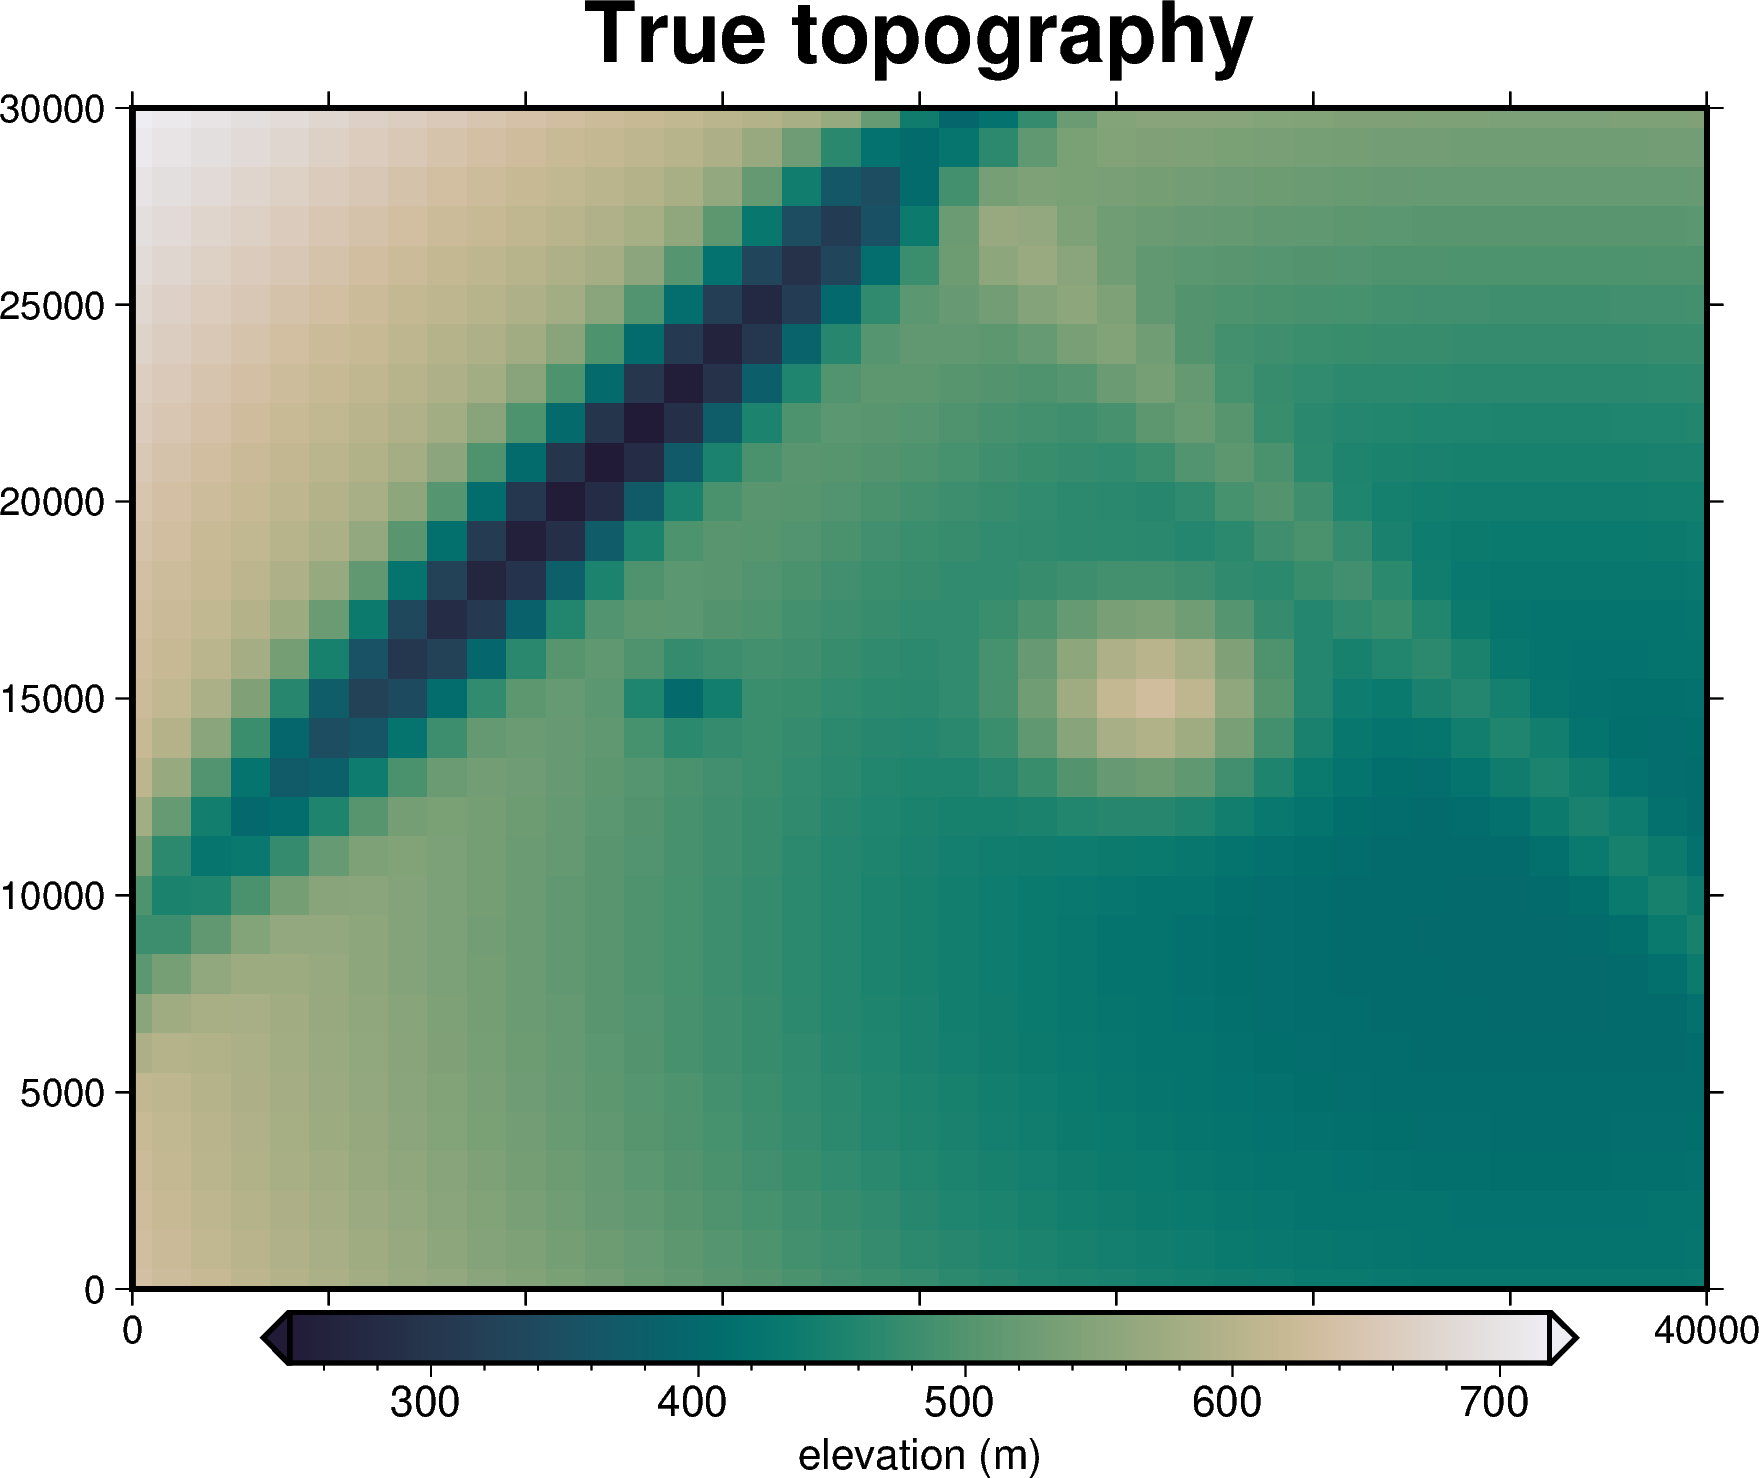

INFO:invert4geom:Standard deviation used for noise: [0.2]


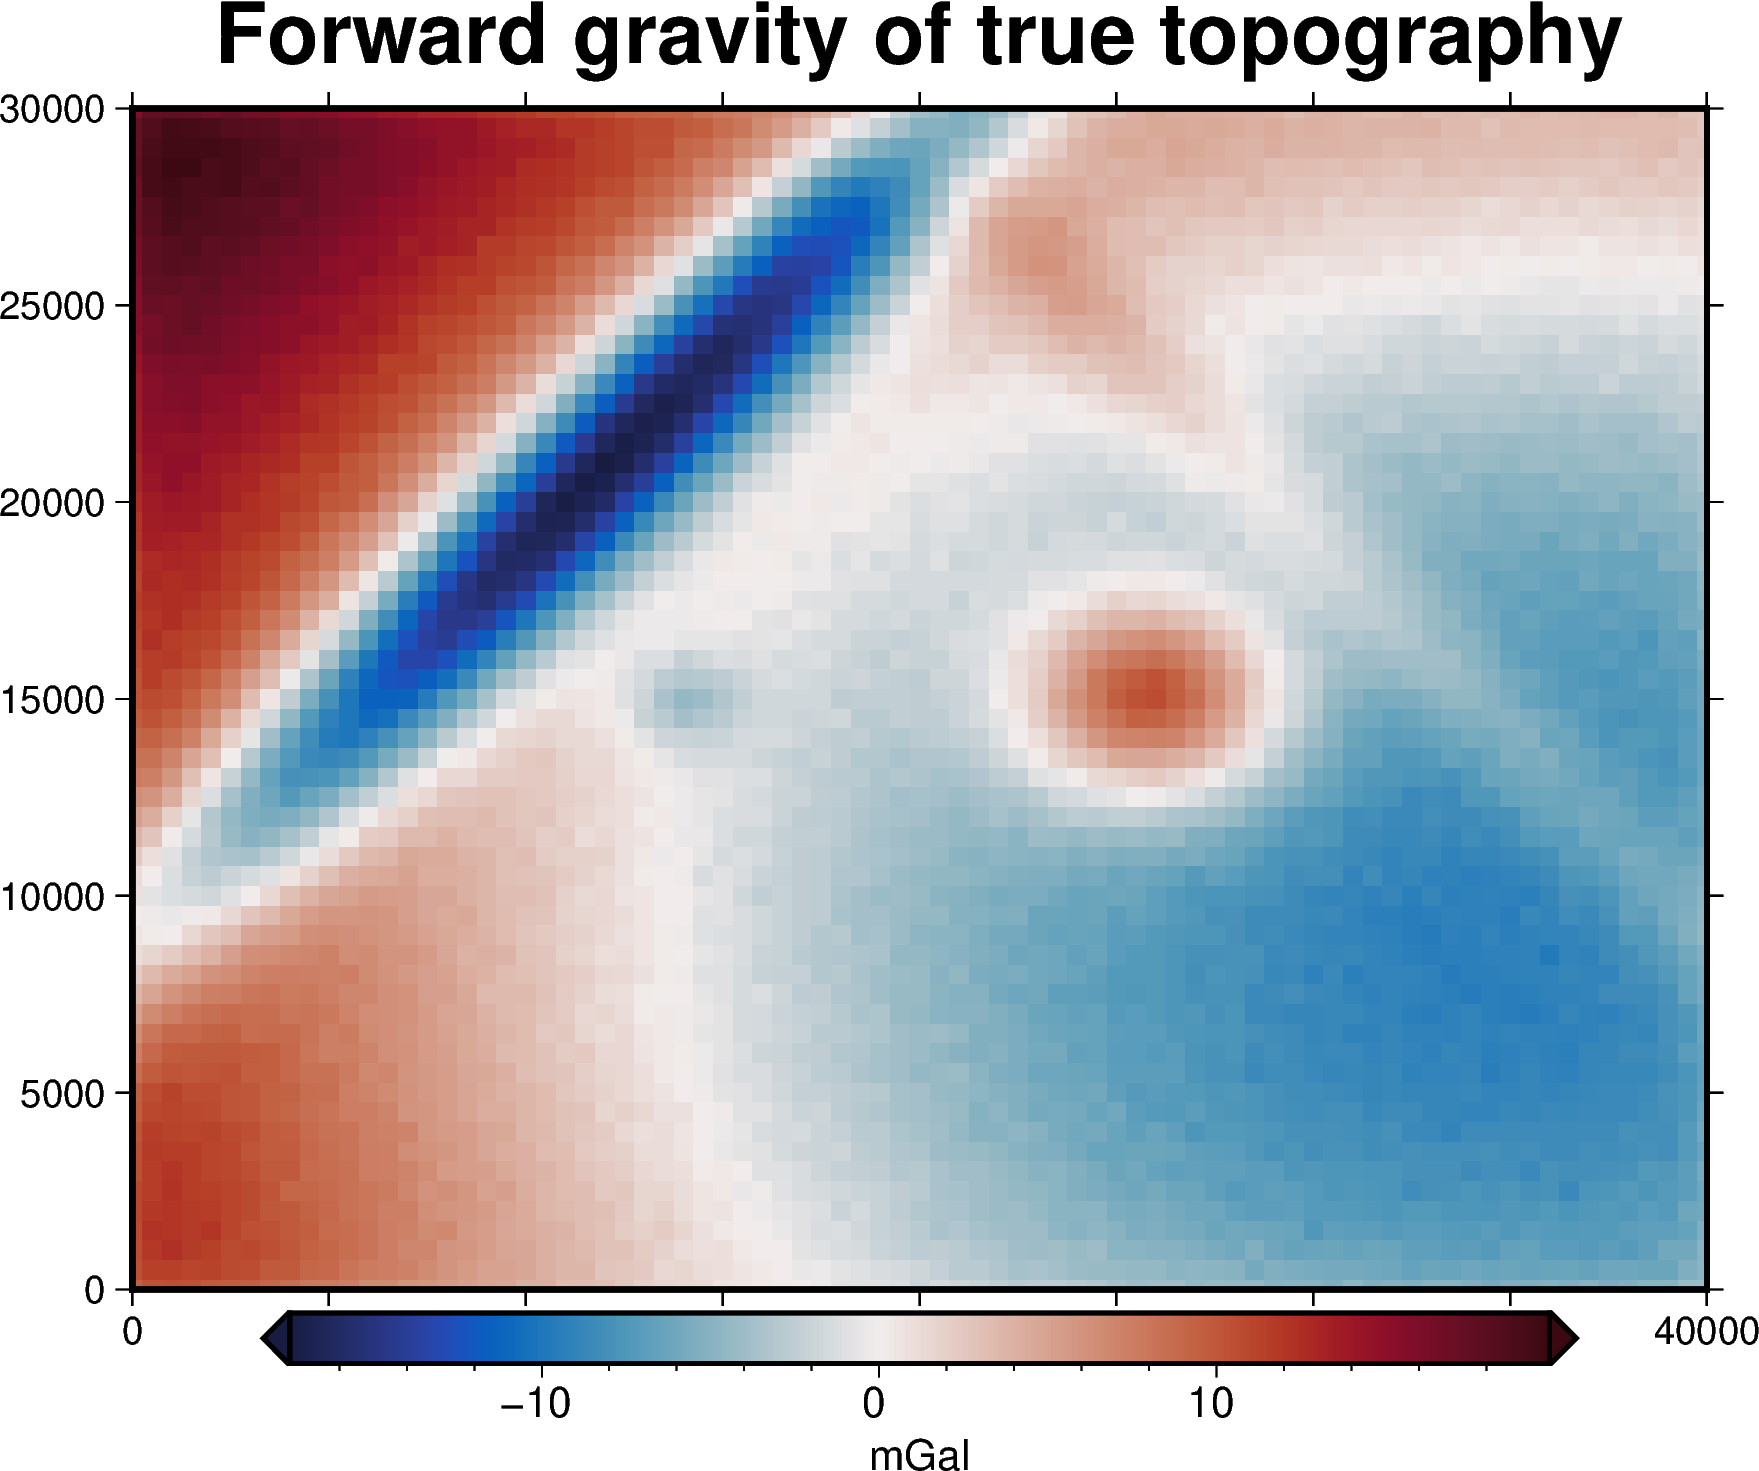

mean of true topography: 492.2704164812973 m 


In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1

(
    true_topography,
    _,
    _,
    grav_df,
) = synthetic.load_synthetic_model(
    spacing=spacing,
    region=region,
    density_contrast=true_density_contrast,
    resample_for_cv=True,
    plot_topography=True,
)

true_zref = true_topography.values.mean()
print(f"mean of true topography: {true_zref} m ")

## Gravity misfit

As in the last notebook, for simplicity here we assume that we know the true density contrast and the reference level of the true topography, and use these values to create our starting model. Note that in a real world scenario, these would be unknowns which would need to be carefully chosen, as explained in the following notebooks.

In [3]:
# create flat topography grid with a constant height equal the mean of the starting
# topography (zref)
starting_topography = xr.full_like(true_topography, true_zref)

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= true_zref, true_density_contrast, -true_density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    true_zref,
    density=density_grid,
)

# since our starting model is flat, the starting gravity is 0
grav_df["starting_gravity"] = 0

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_df = regional.regional_separation(
    method="constant",
    constant=0,
    grav_df=grav_df,
)

grav_df.describe()

,northing,easting,upward,gravity_anomaly,starting_gravity,misfit,reg,res
count,4941.000000,4941.000000,4941.0,4941.000000,4941.0,4941.000000,4941.0,4941.000000
mean,15000.000000,20000.000000,1000.0,-0.223240,0.0,-0.223240,0.0,-0.223240
std,8804.299419,11691.635129,0.0,7.133964,0.0,7.133964,0.0,7.133964
min,0.000000,0.000000,1000.0,-17.473578,0.0,-17.473578,0.0,-17.473578
25%,7500.000000,10000.000000,1000.0,-5.646930,0.0,-5.646930,0.0,-5.646930
50%,15000.000000,20000.000000,1000.0,-1.169310,0.0,-1.169310,0.0,-1.169310
75%,22500.000000,30000.000000,1000.0,3.597909,0.0,3.597909,0.0,3.597909
max,30000.000000,40000.000000,1000.0,19.868717,0.0,19.868717,0.0,19.868717


## Get Cross Validation Score

We will perform an inversion with a single damping value and calculate a `score` for it. The grid shows how to `score` is calculated, as the RMS difference between the predicted and observed gravity data.

  0%|                                                                                 | 0/3670 [00:00<?, ?it/s…

np.float64(0.2611060802211987)

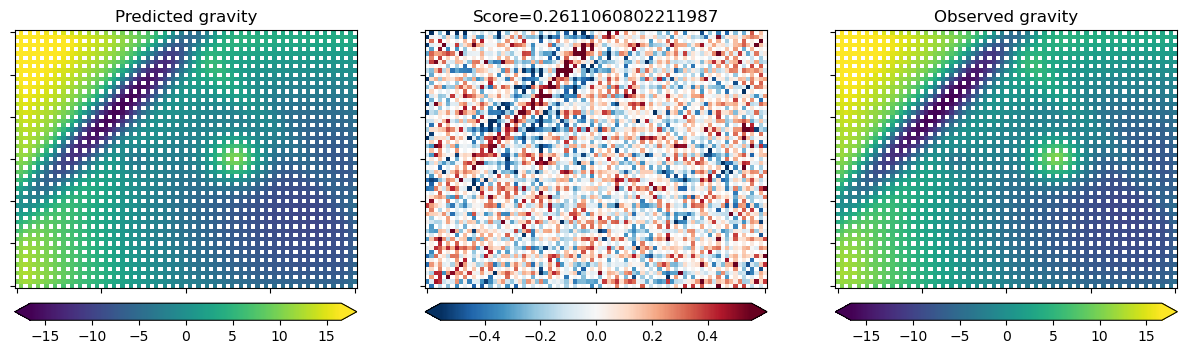

In [4]:
# set kwargs to pass to the inversion
kwargs = {
    "prism_layer": starting_prisms,
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": 0.45,  # gravity error is .2 mGal or L2-norm of ~0.45
    "delta_l2_norm_tolerance": 1.005,
}

# run inversion, calculate the score, and plot the predicted and observed gravity for
# the testing dataset
score, results = cross_validation.grav_cv_score(
    training_data=grav_df[grav_df.test == False],
    testing_data=grav_df[grav_df.test == True],
    solver_damping=0.1,
    progressbar=True,
    plot=True,
    **kwargs,
)
score

## Cross Validation
Now we can repeat this with a range of damping parameters to find the optimal (lowest) score.

This is a classic optimization problem, where we vary the damping parameter to find which value produces the best score. For this we use the Python package [Optuna](https://optuna.readthedocs.io/en/stable/index.html). 

For each trial a `.pickle` file containing the inversion results will be created. Once all trials are complete, all but the best trial's pickle files will be deleted. Additionally, another `.pickle` file will be created containing the Optuna study object with all the trial information and results.

By default, `optimize_inversion_damping` will use a sampler to choose damping values between the provided `damping_limits` and repeat this `n_trials` times. This may skip large portions of the parameter space. If instead you would like to systematically test damping values at a constant interval, you can set `grid_search` to True, and this will test all damping values as defined by:

```python
np.logspace(<<exponent of lower damping limit>>, <<exponent of upper damping limit>>, n_trials)
```

  0%|          | 0/8 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 


INFO:invert4geom:	trial number: 3


INFO:invert4geom:	parameter: {'damping': 0.0517947467923121}


INFO:invert4geom:	scores: [0.25059211896003586]


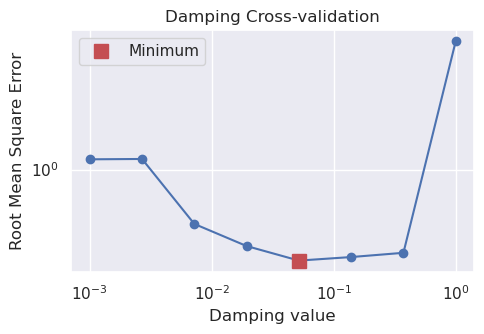

In [5]:
study, inversion_results = optimization.optimize_inversion_damping(
    training_df=grav_df[grav_df.test == False],
    testing_df=grav_df[grav_df.test == True],
    damping_limits=(0.001, 1),
    n_trials=8,
    grid_search=True,
    # plot_grids=True,
    fname="tmp/damping_CV",
    **kwargs,
)

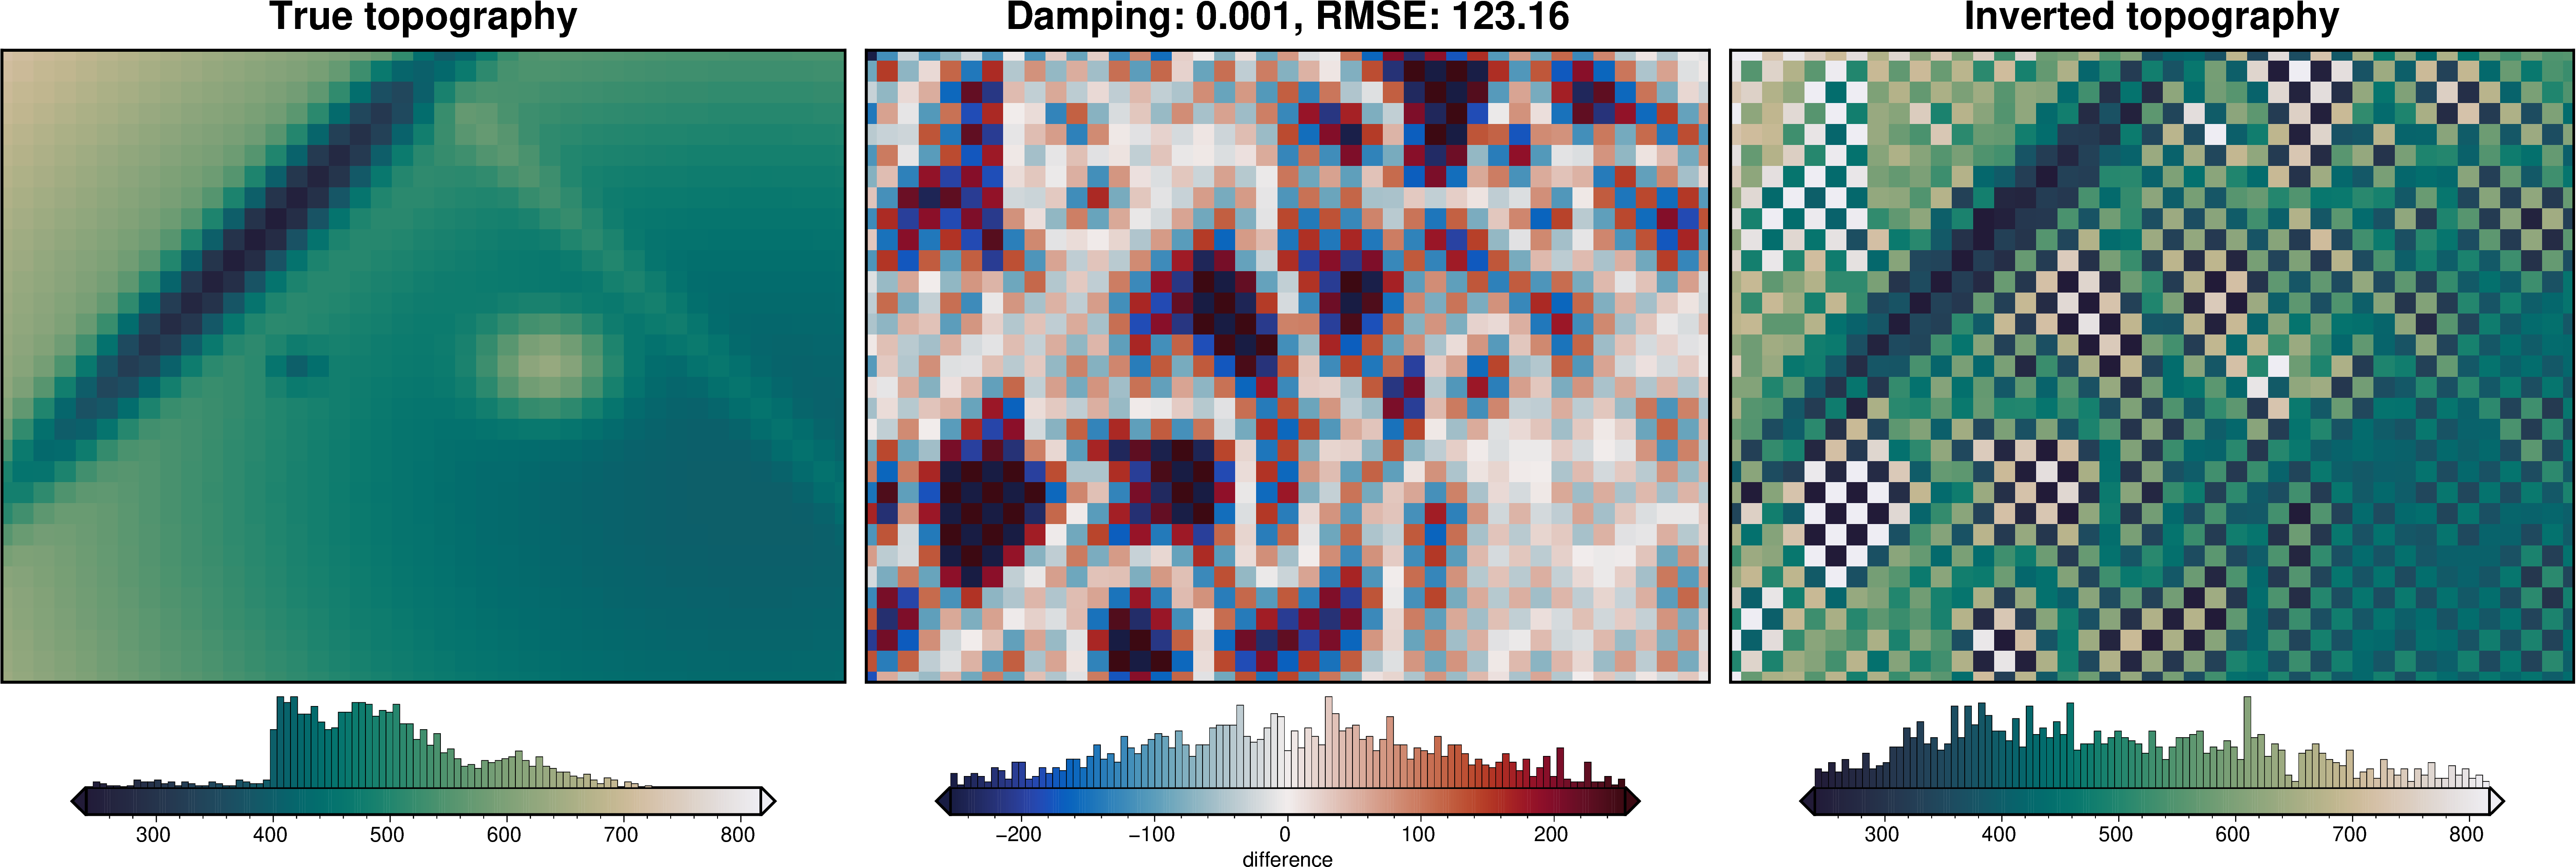

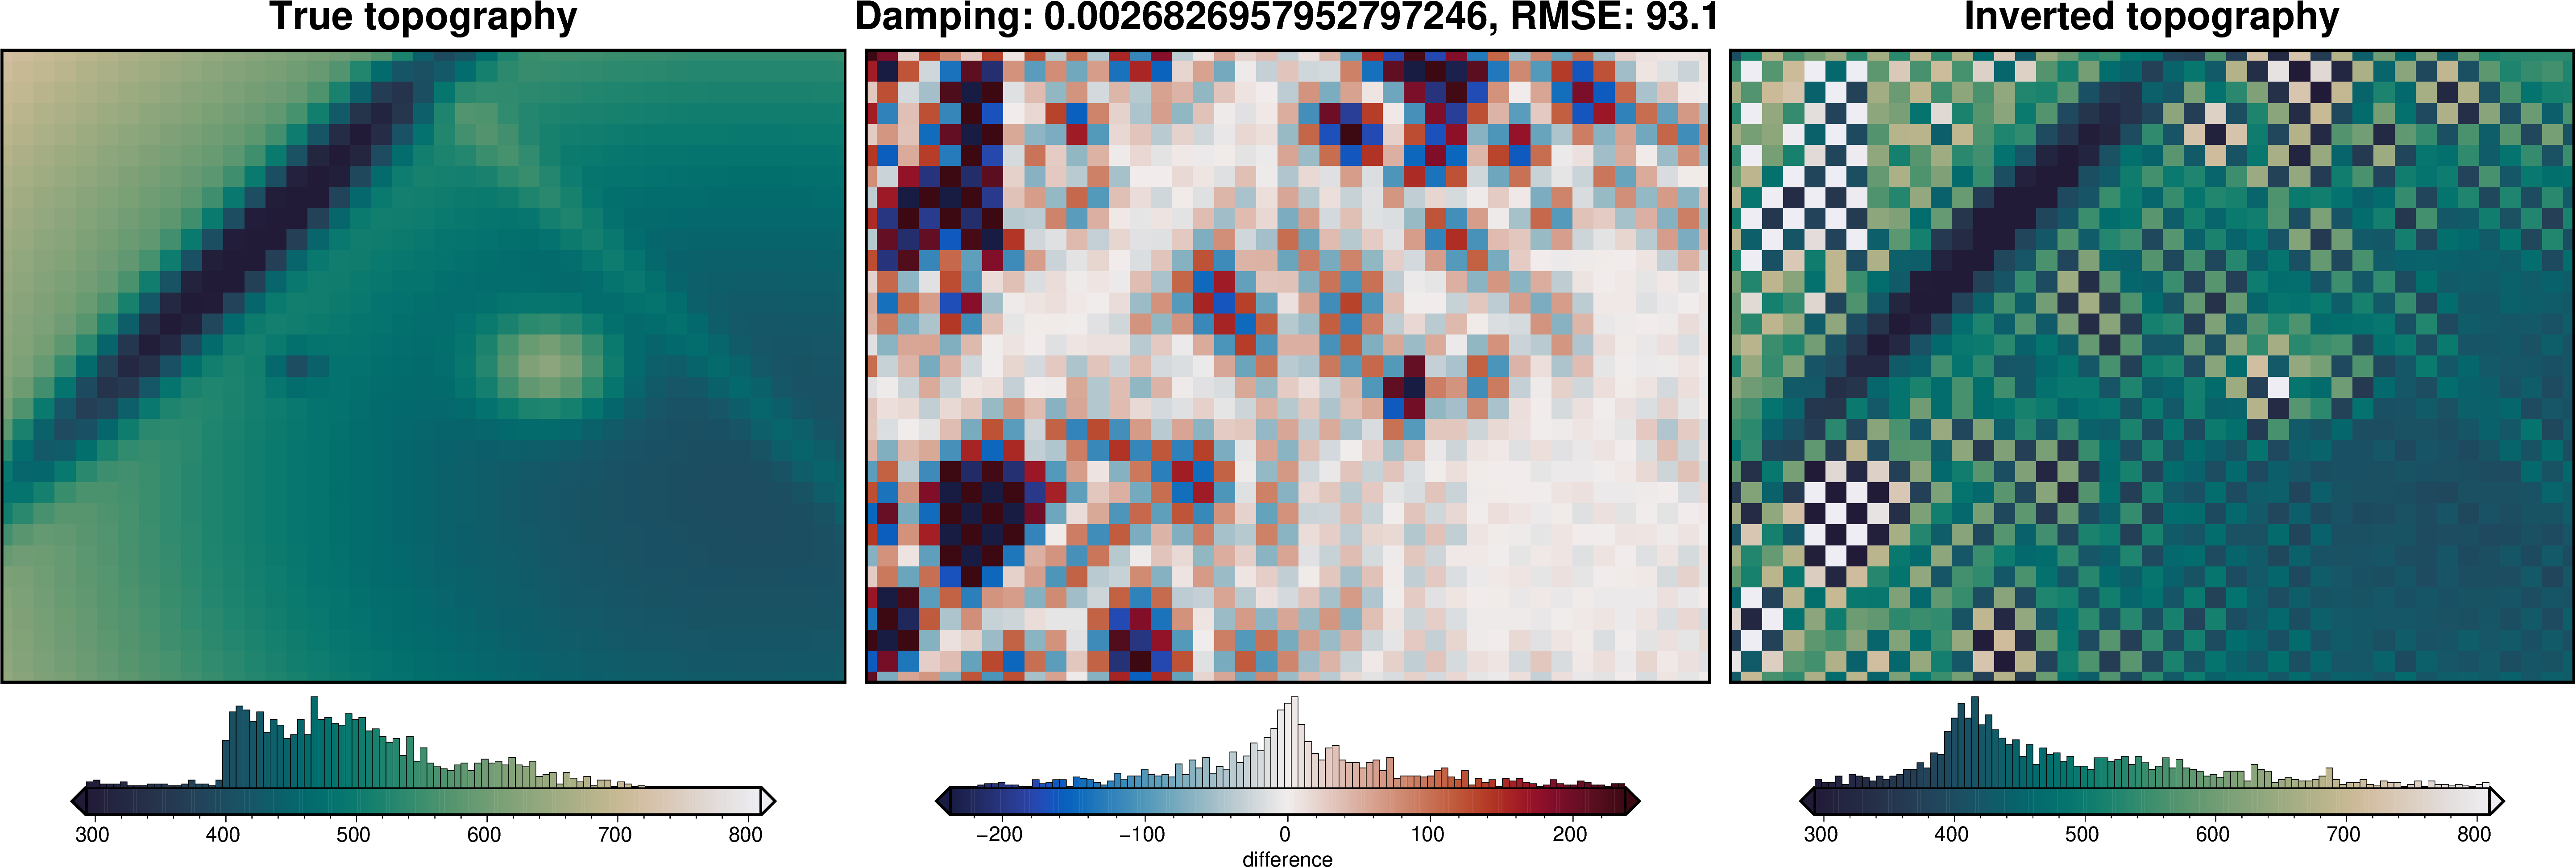

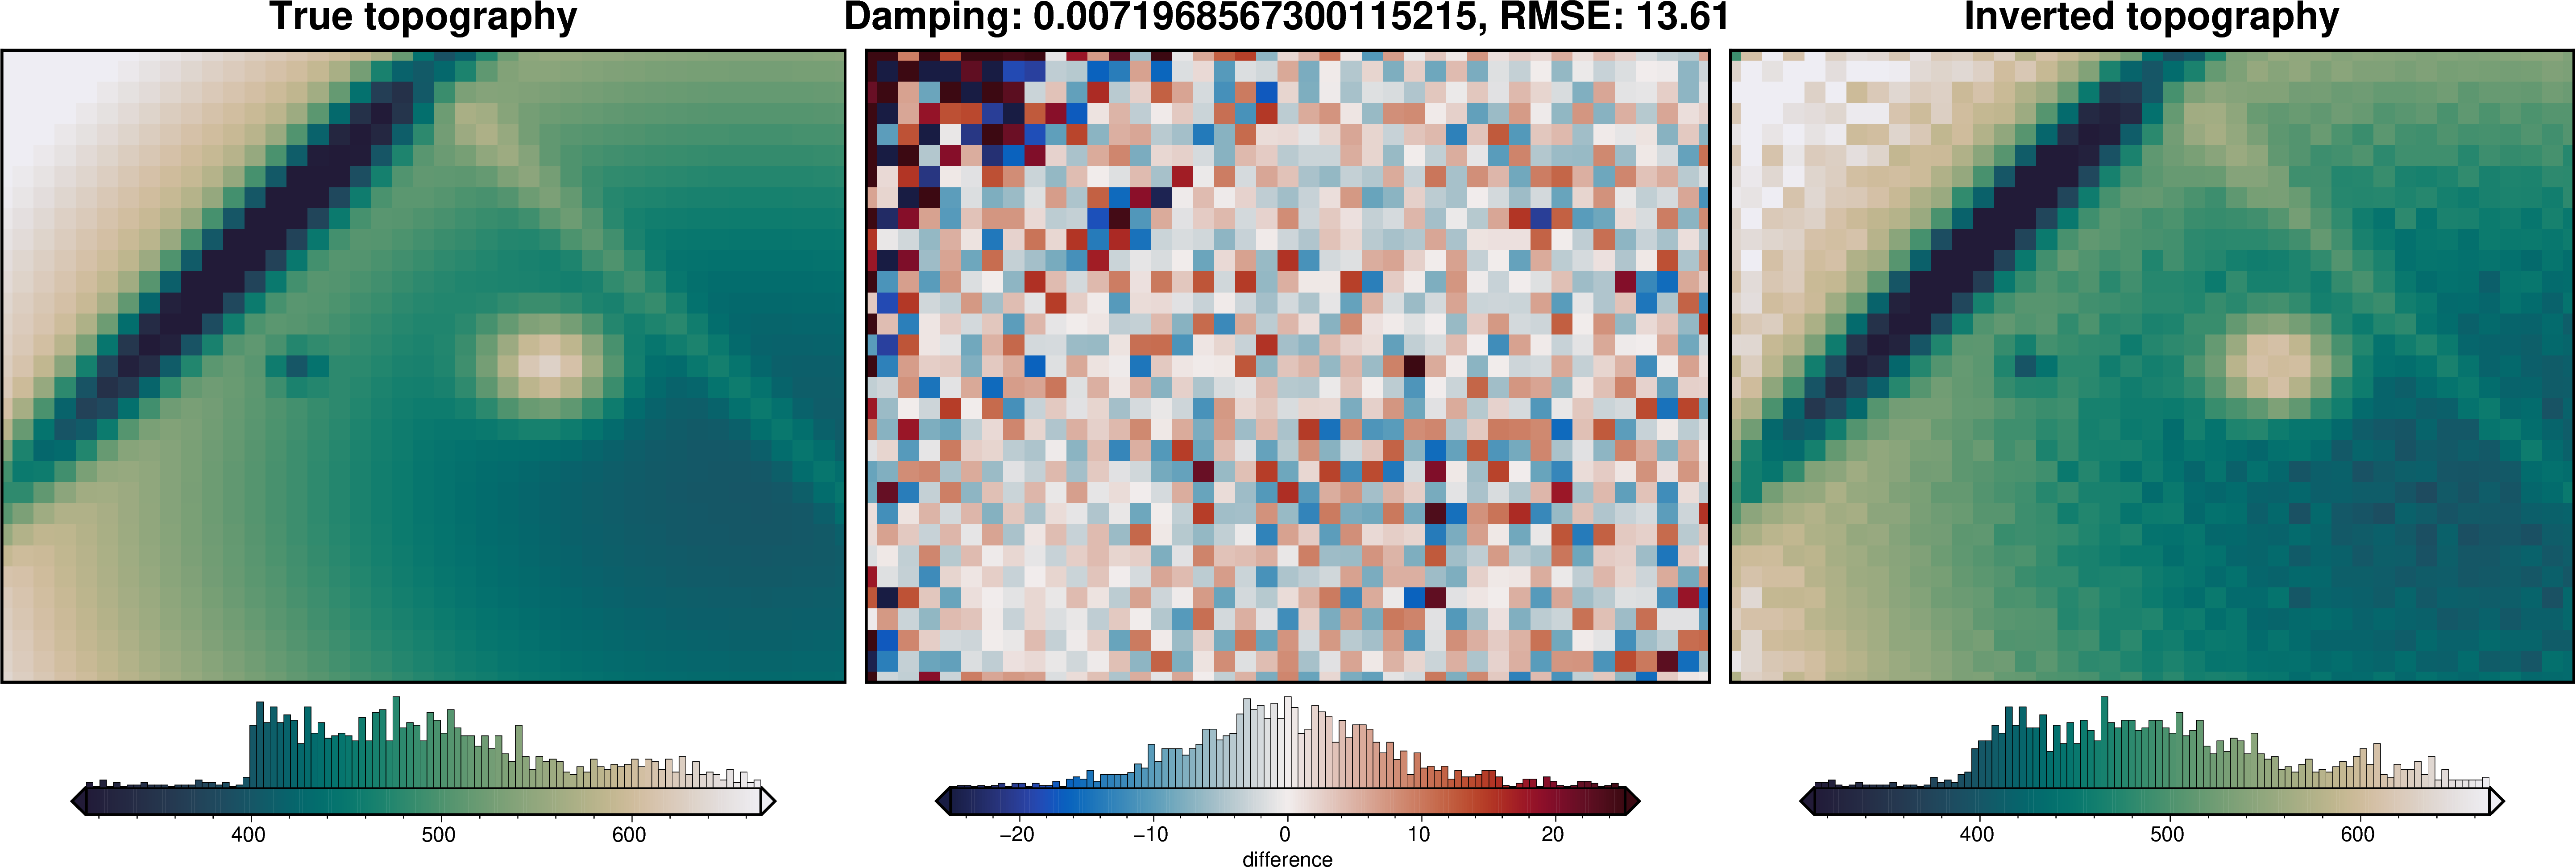

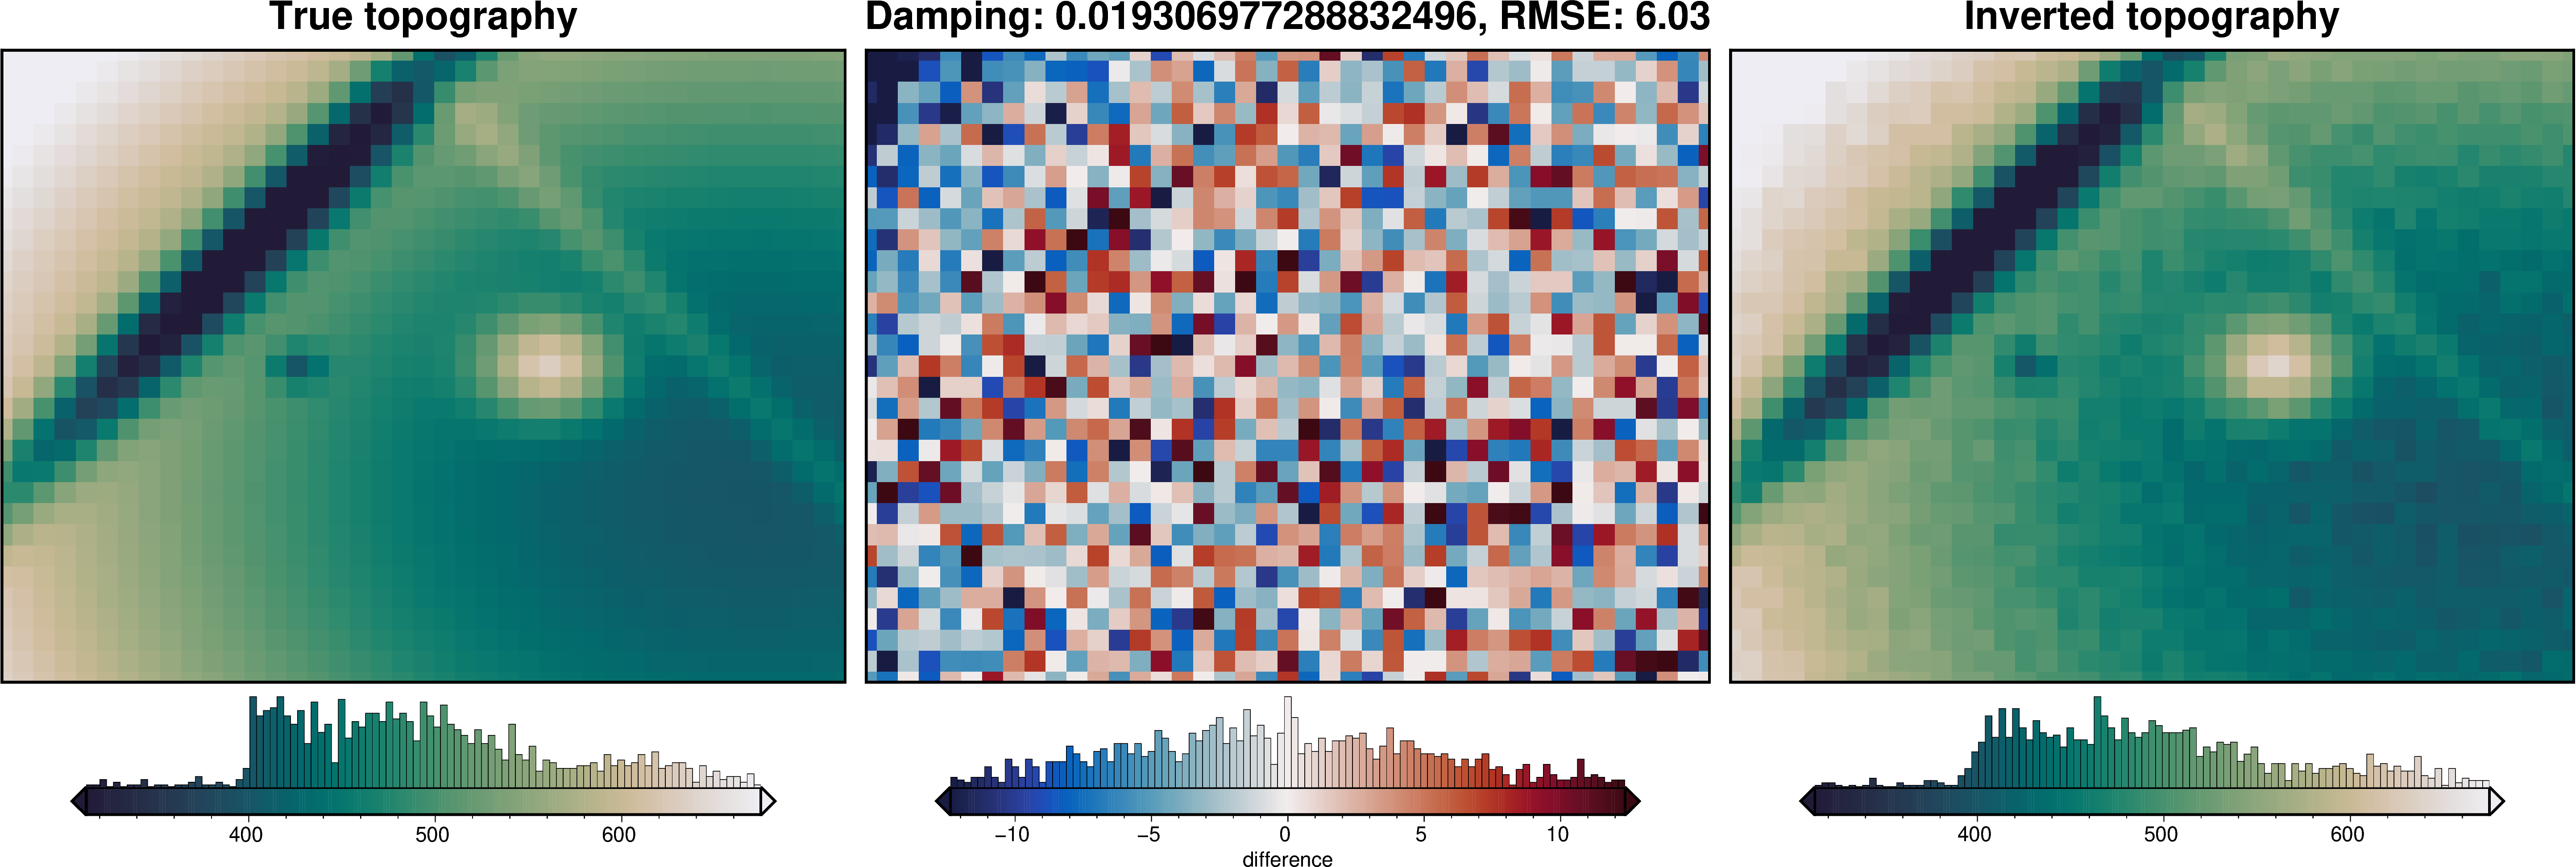

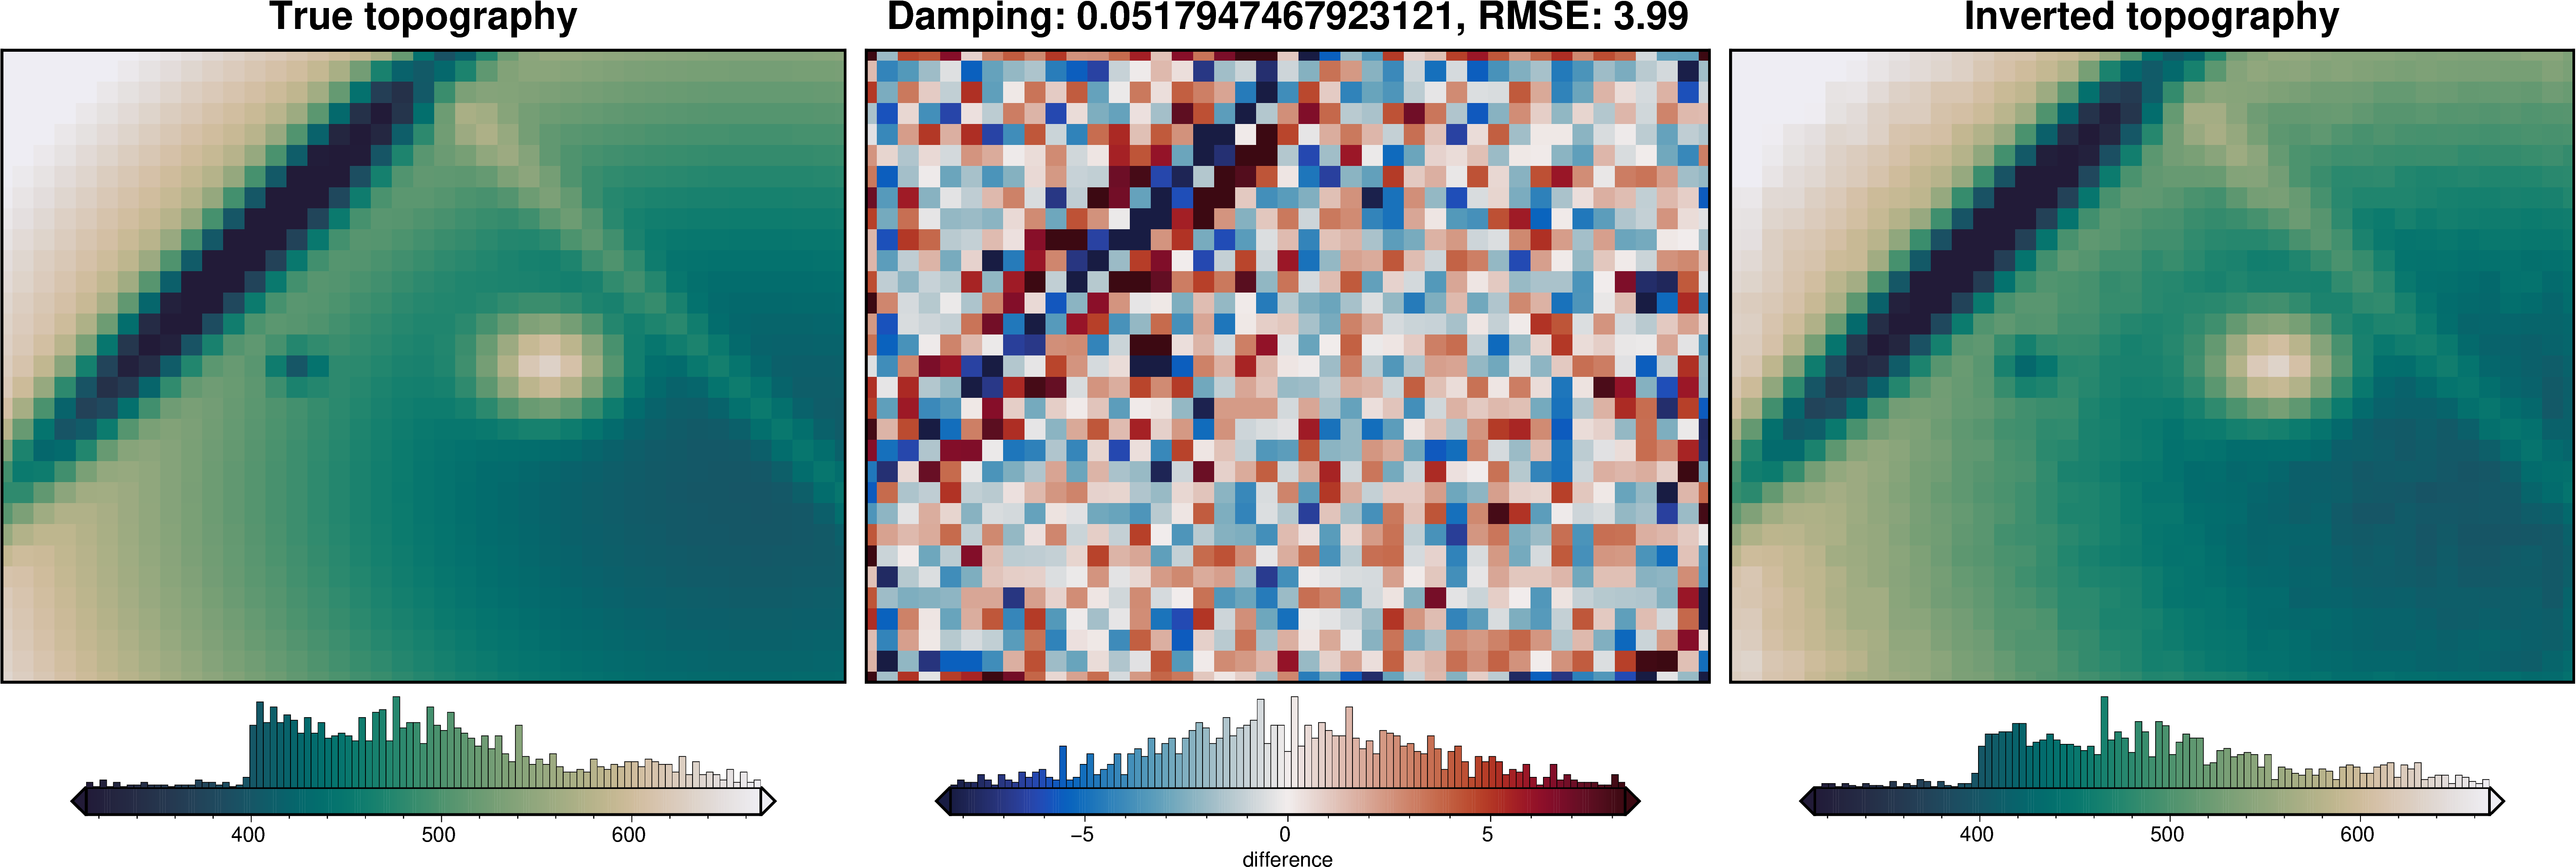

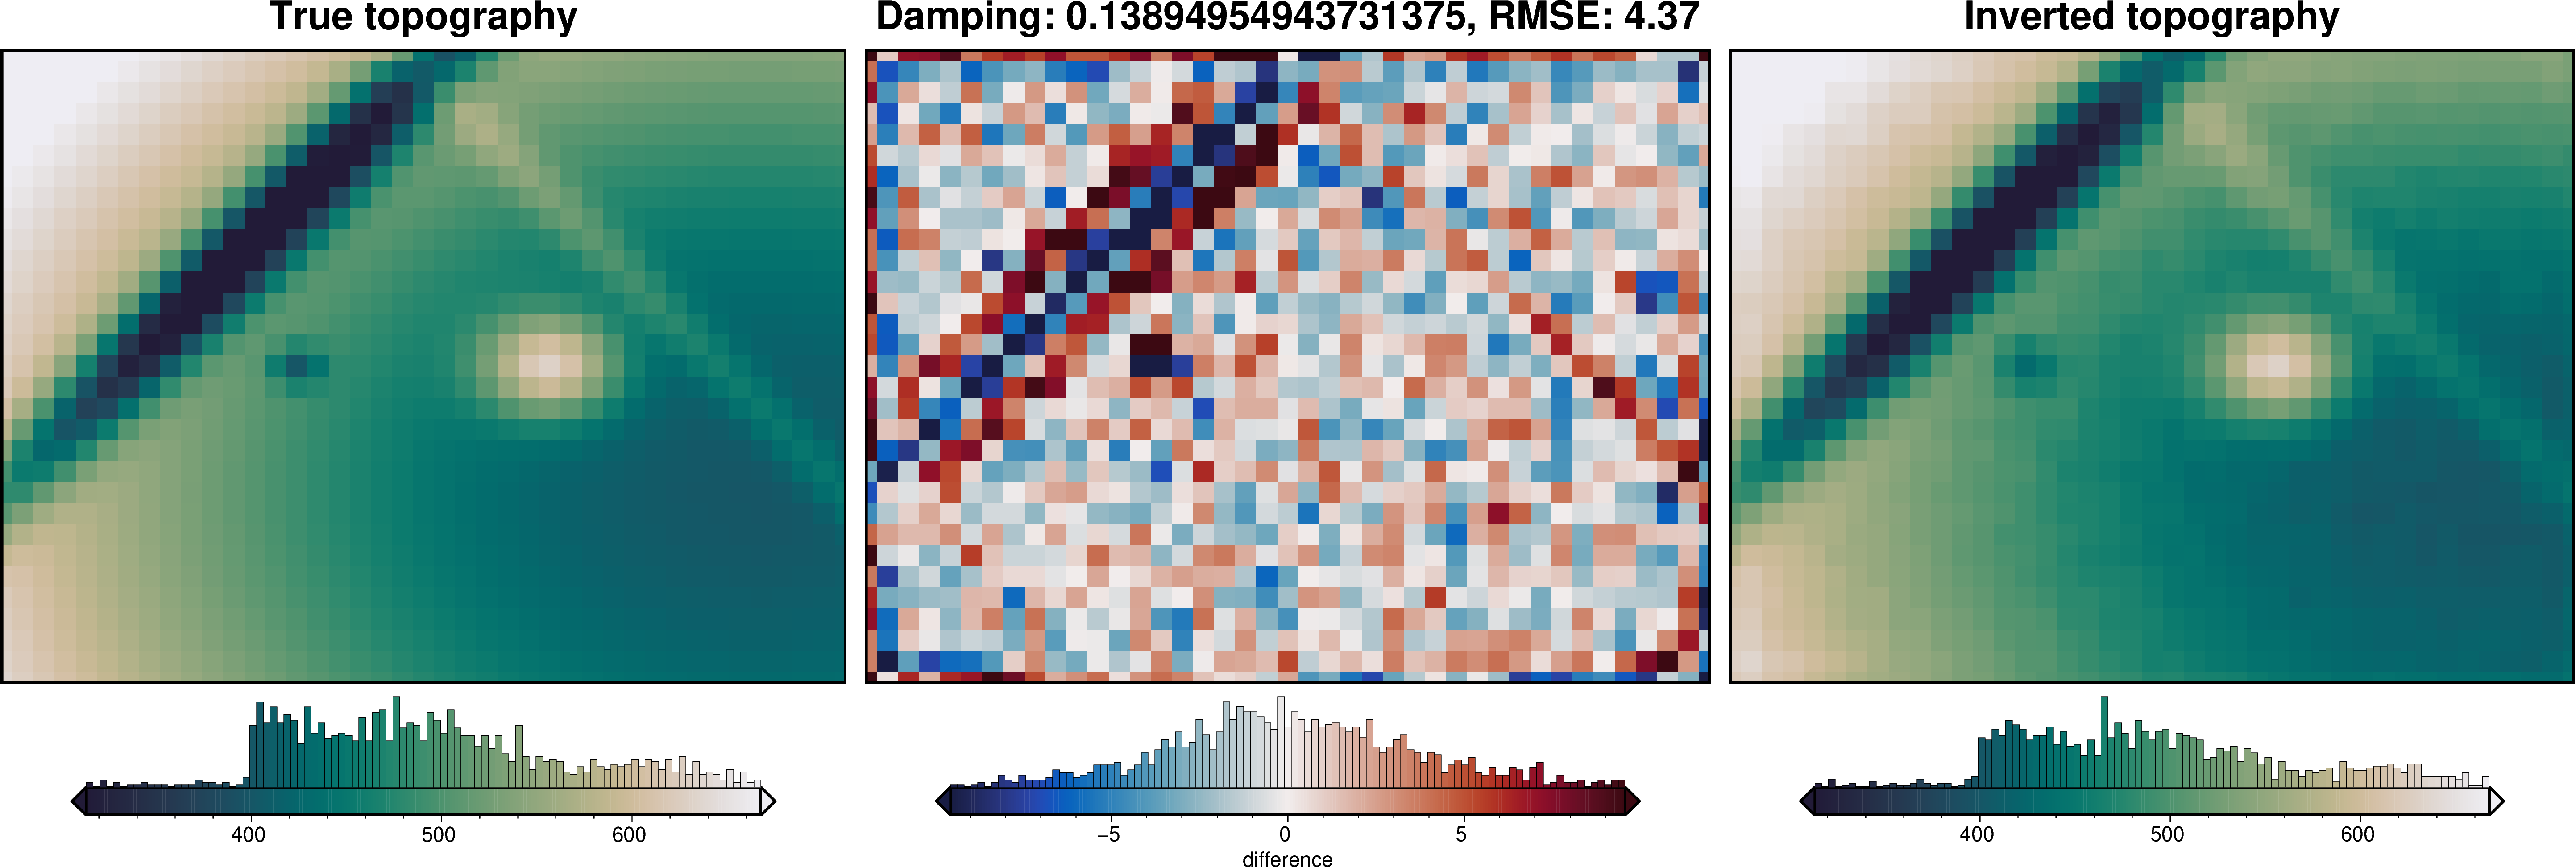

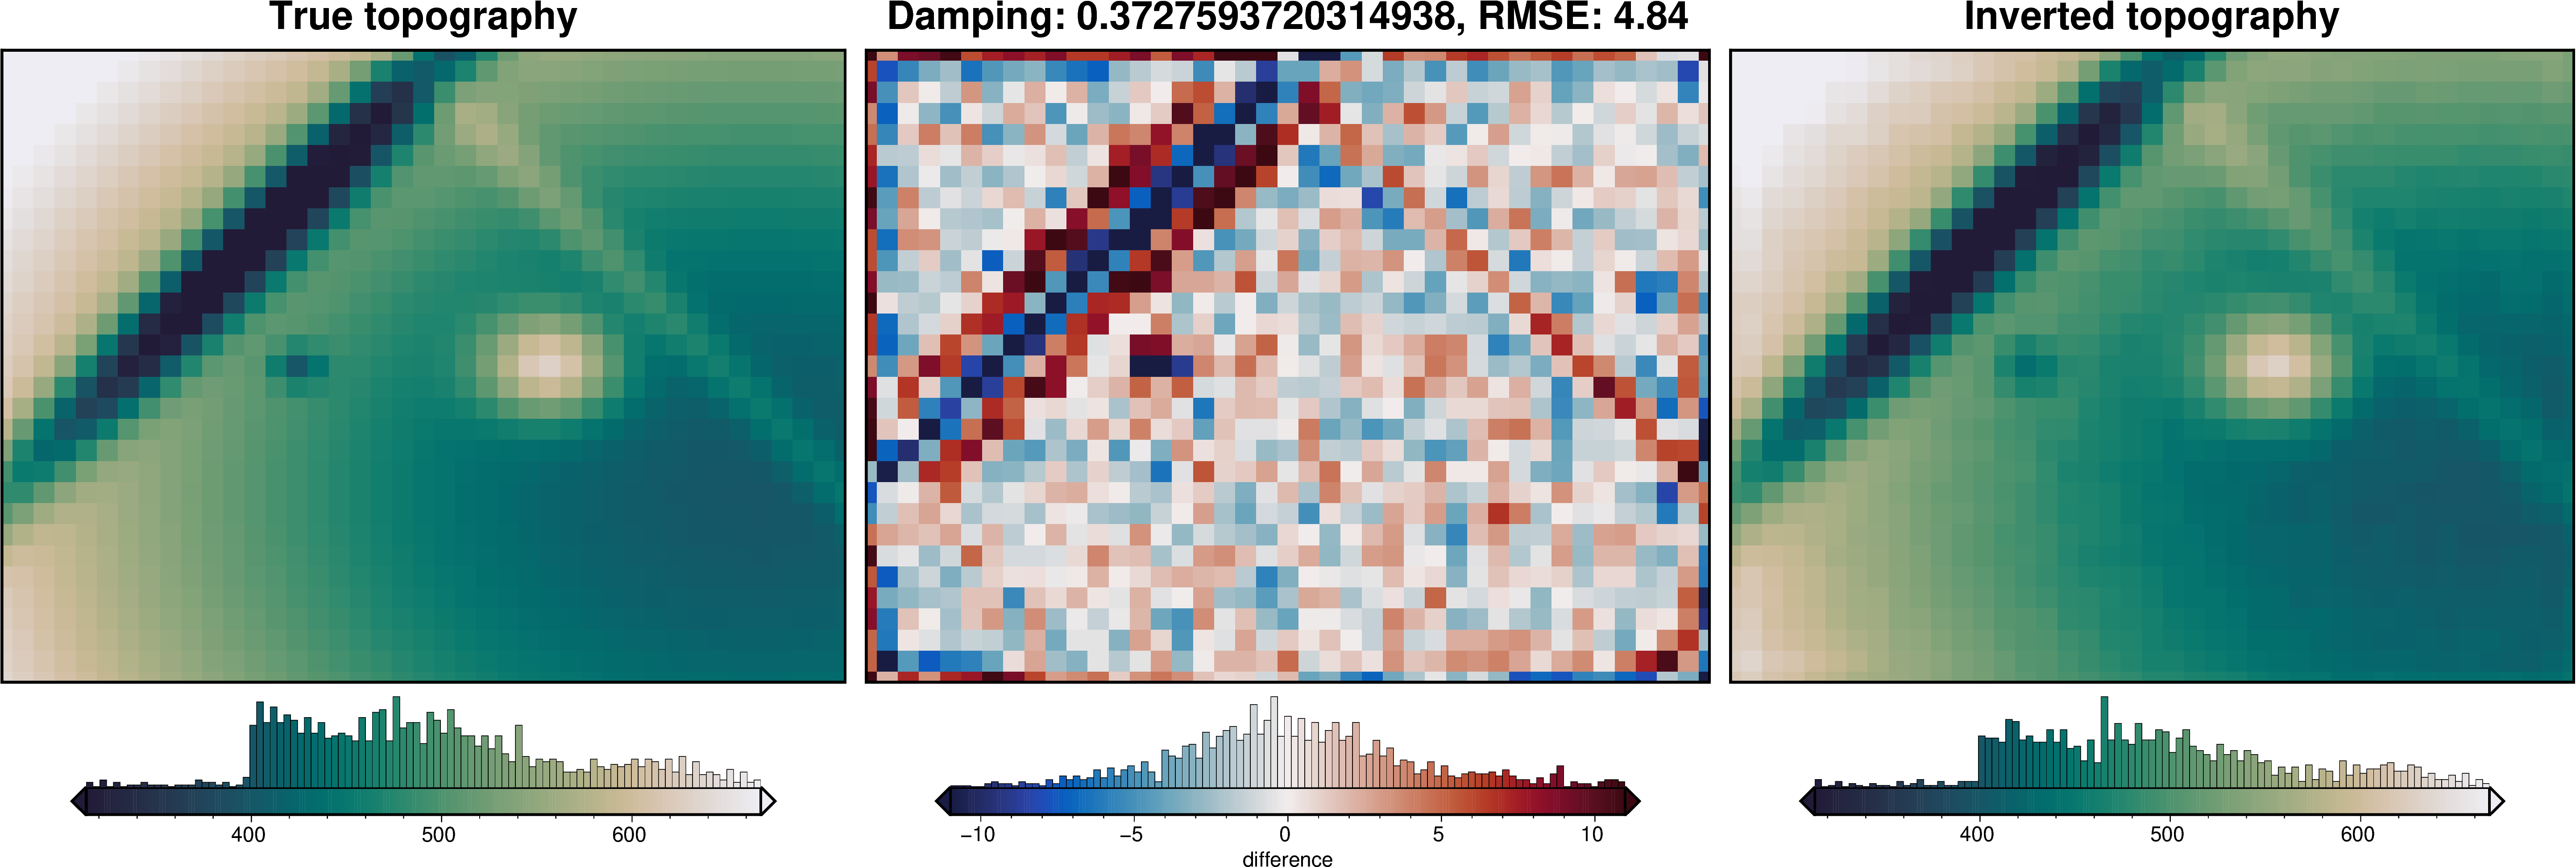

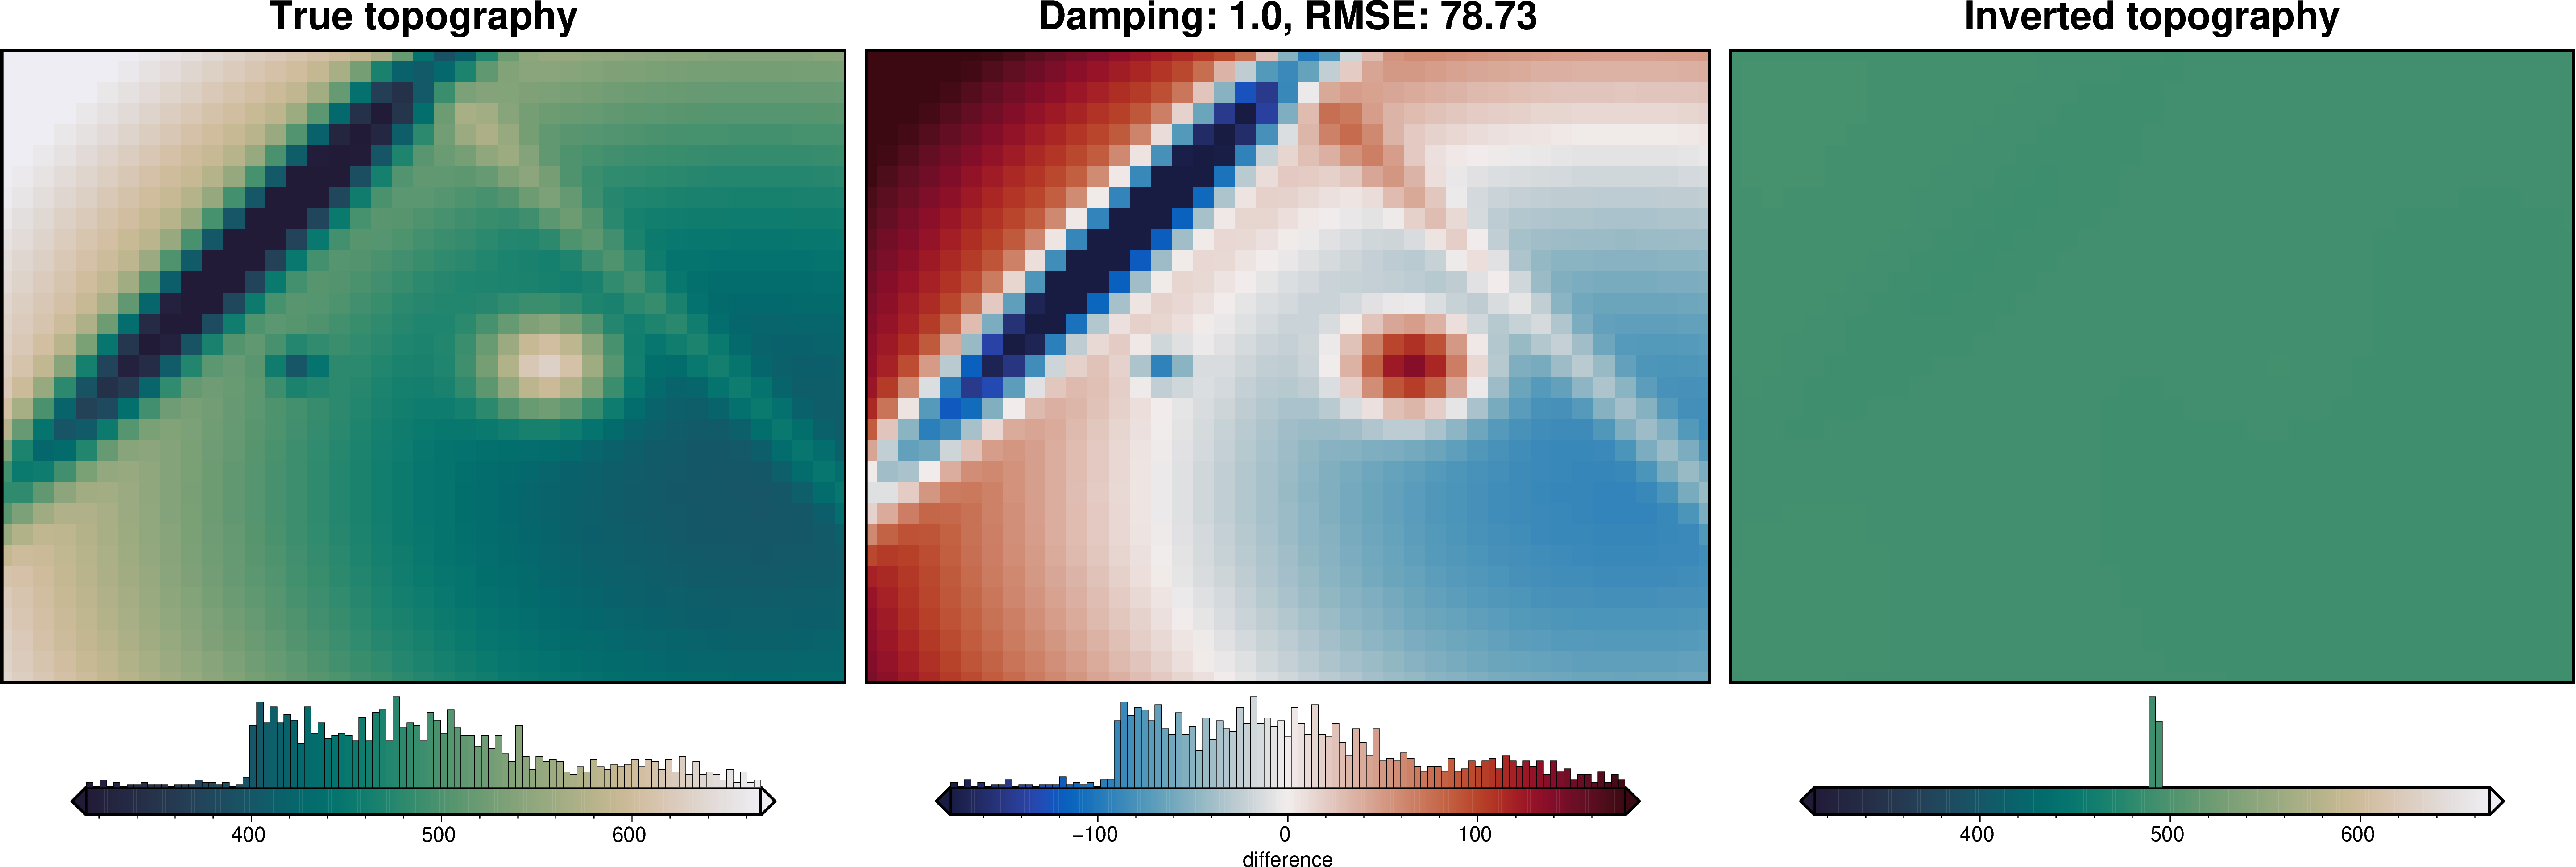

In [6]:
dampings = [
    (t.params["damping"], t.user_attrs["results"][0]) for t in study.get_trials()
]
dampings = sorted(dampings, key=lambda x: x[0])

for damp, df in dampings:
    final_topography = df.set_index(["northing", "easting"]).to_xarray().topo

    _ = polar_utils.grd_compare(
        true_topography,
        final_topography,
        plot=True,
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title=f"Damping: {damp}",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
    )

In [7]:
# # import pathlib
# # import pickle

# # to re-load the study from the saved pickle file
# with pathlib.Path("tmp/damping_CV.pickle").open("rb") as f:
#     study = pickle.load(f)

# # to re-load the inversion results from the saved pickle file
# with pathlib.Path(f"{study.best_trial.user_attrs["fname"]}.pickle").open("rb") as f:
#     inversion_results = pickle.load(f)

## Plot inversion results using optimal value

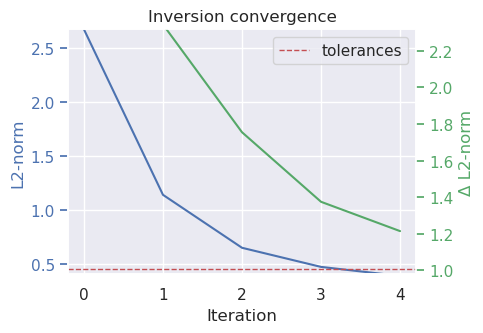

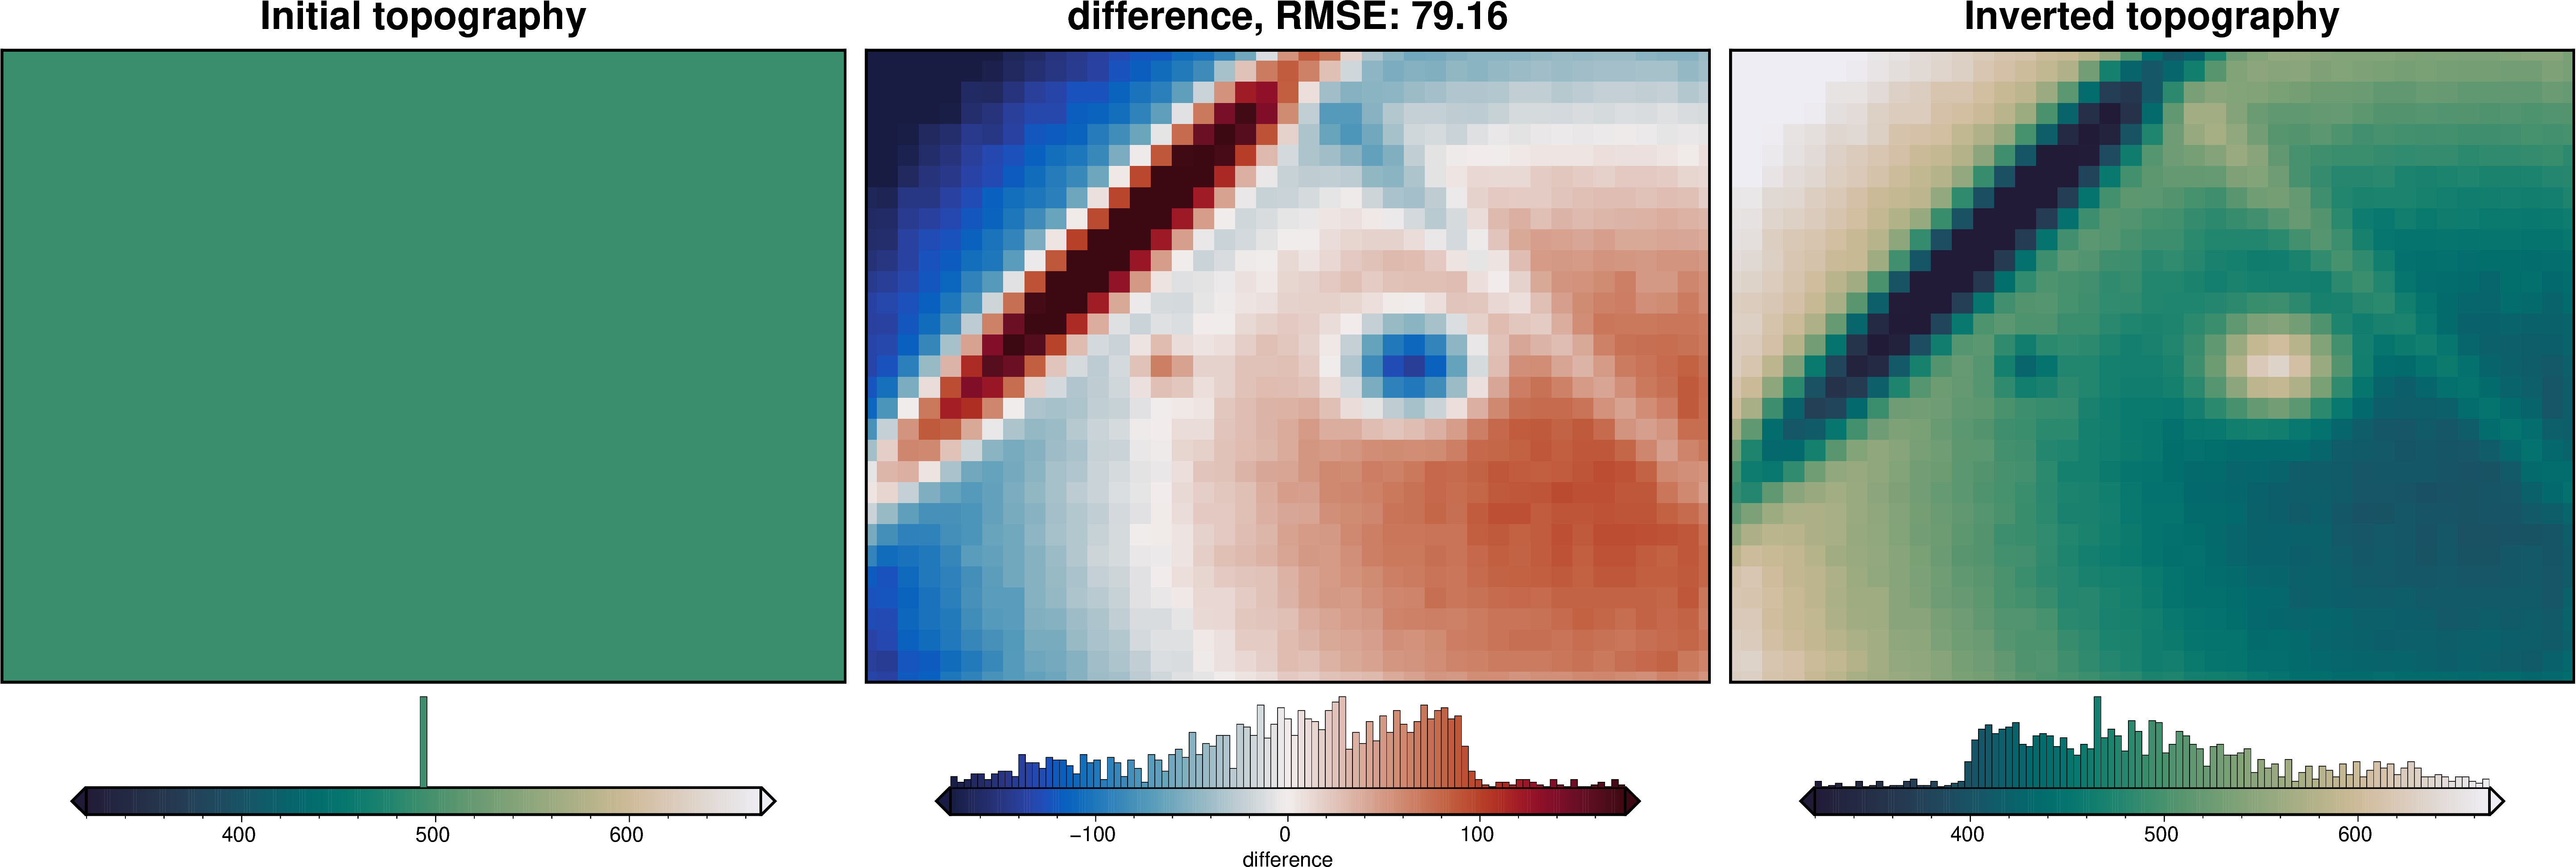

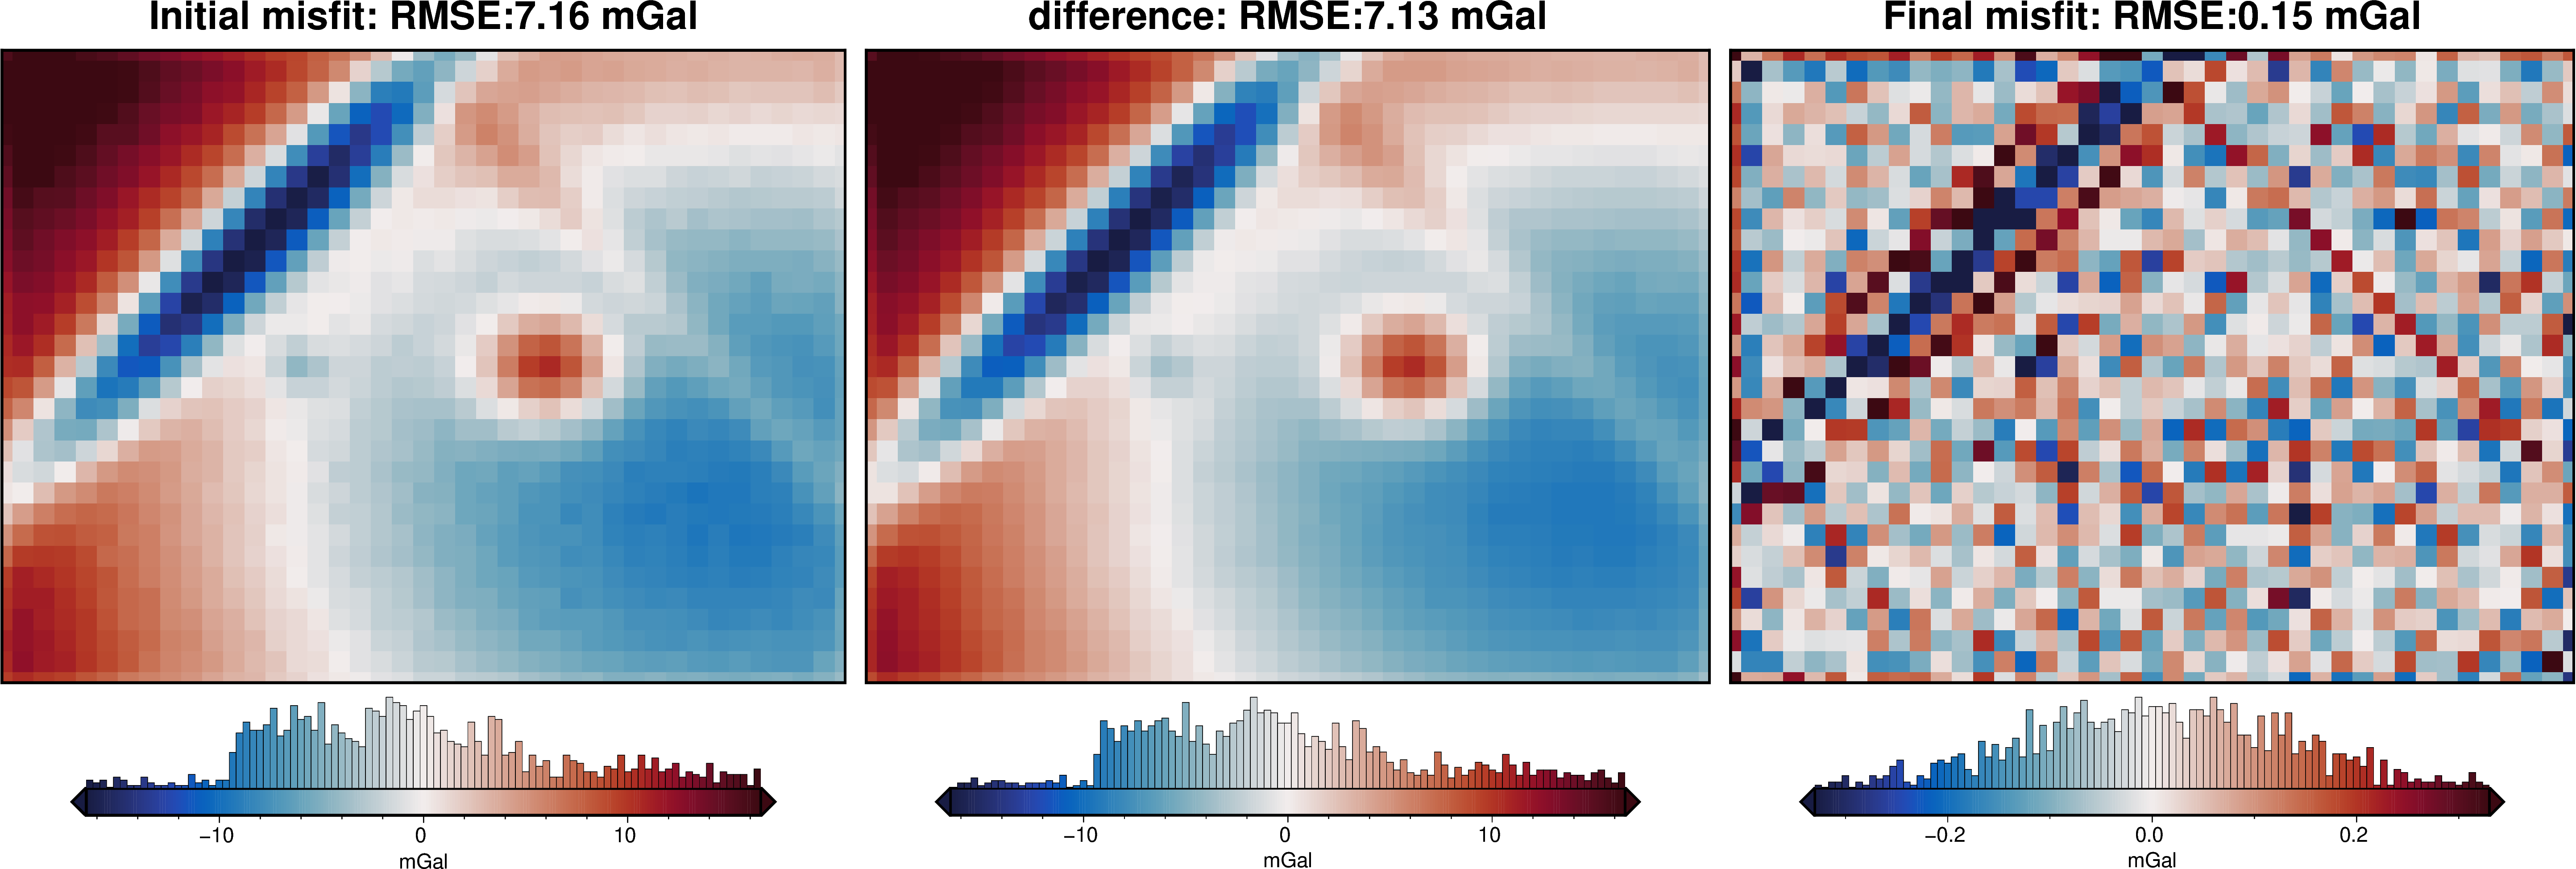

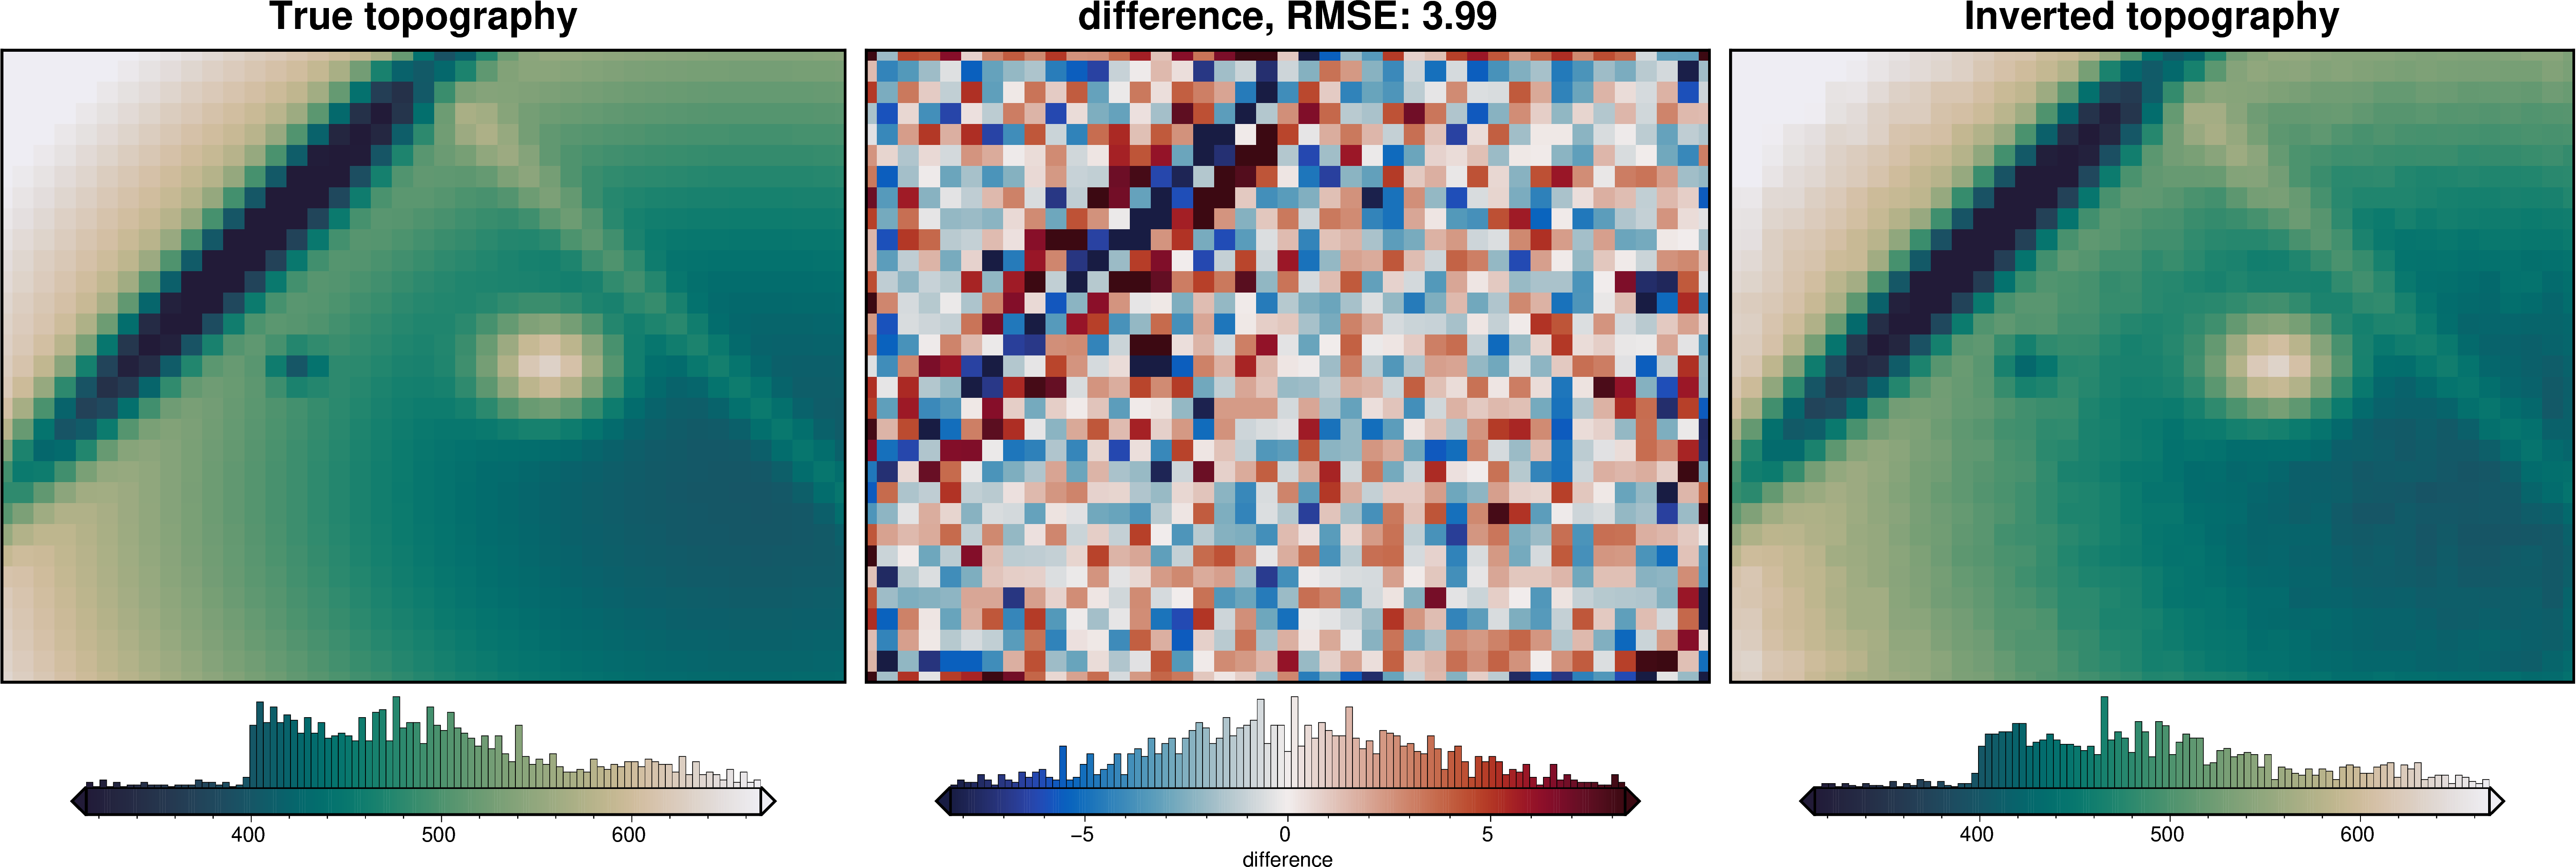

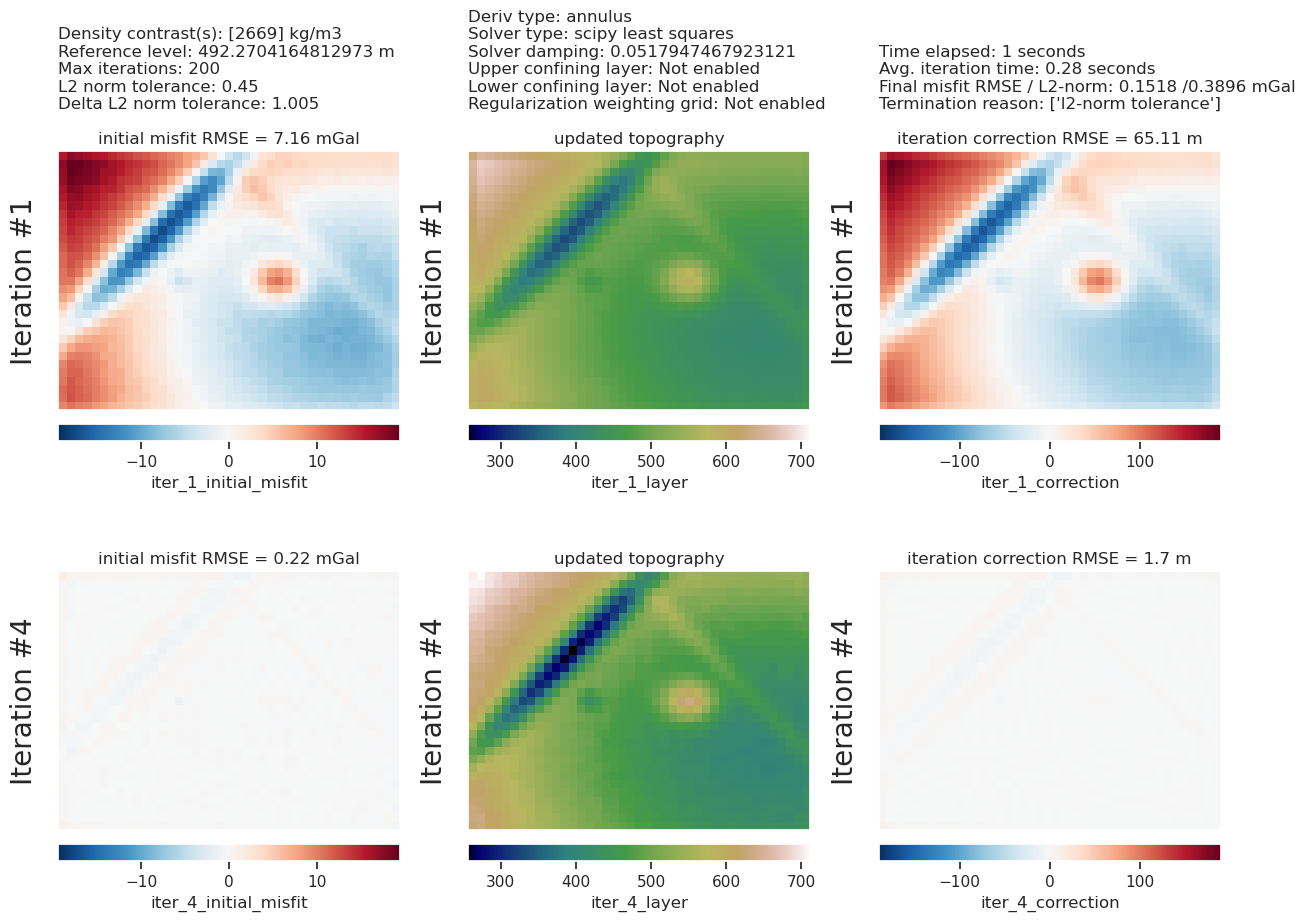

In [8]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    # diff_lims=(-20, 20),
)

## Run inversion with poor choice of damping value

In [9]:
# set Python's logging level
logging.getLogger().setLevel(logging.WARNING)

# add new solver_damping value to kwargs
kwargs["solver_damping"] = 0.005

results = inversion.run_inversion(
    grav_df=grav_df[grav_df.test == False],  # , we can exclude the testing data now
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

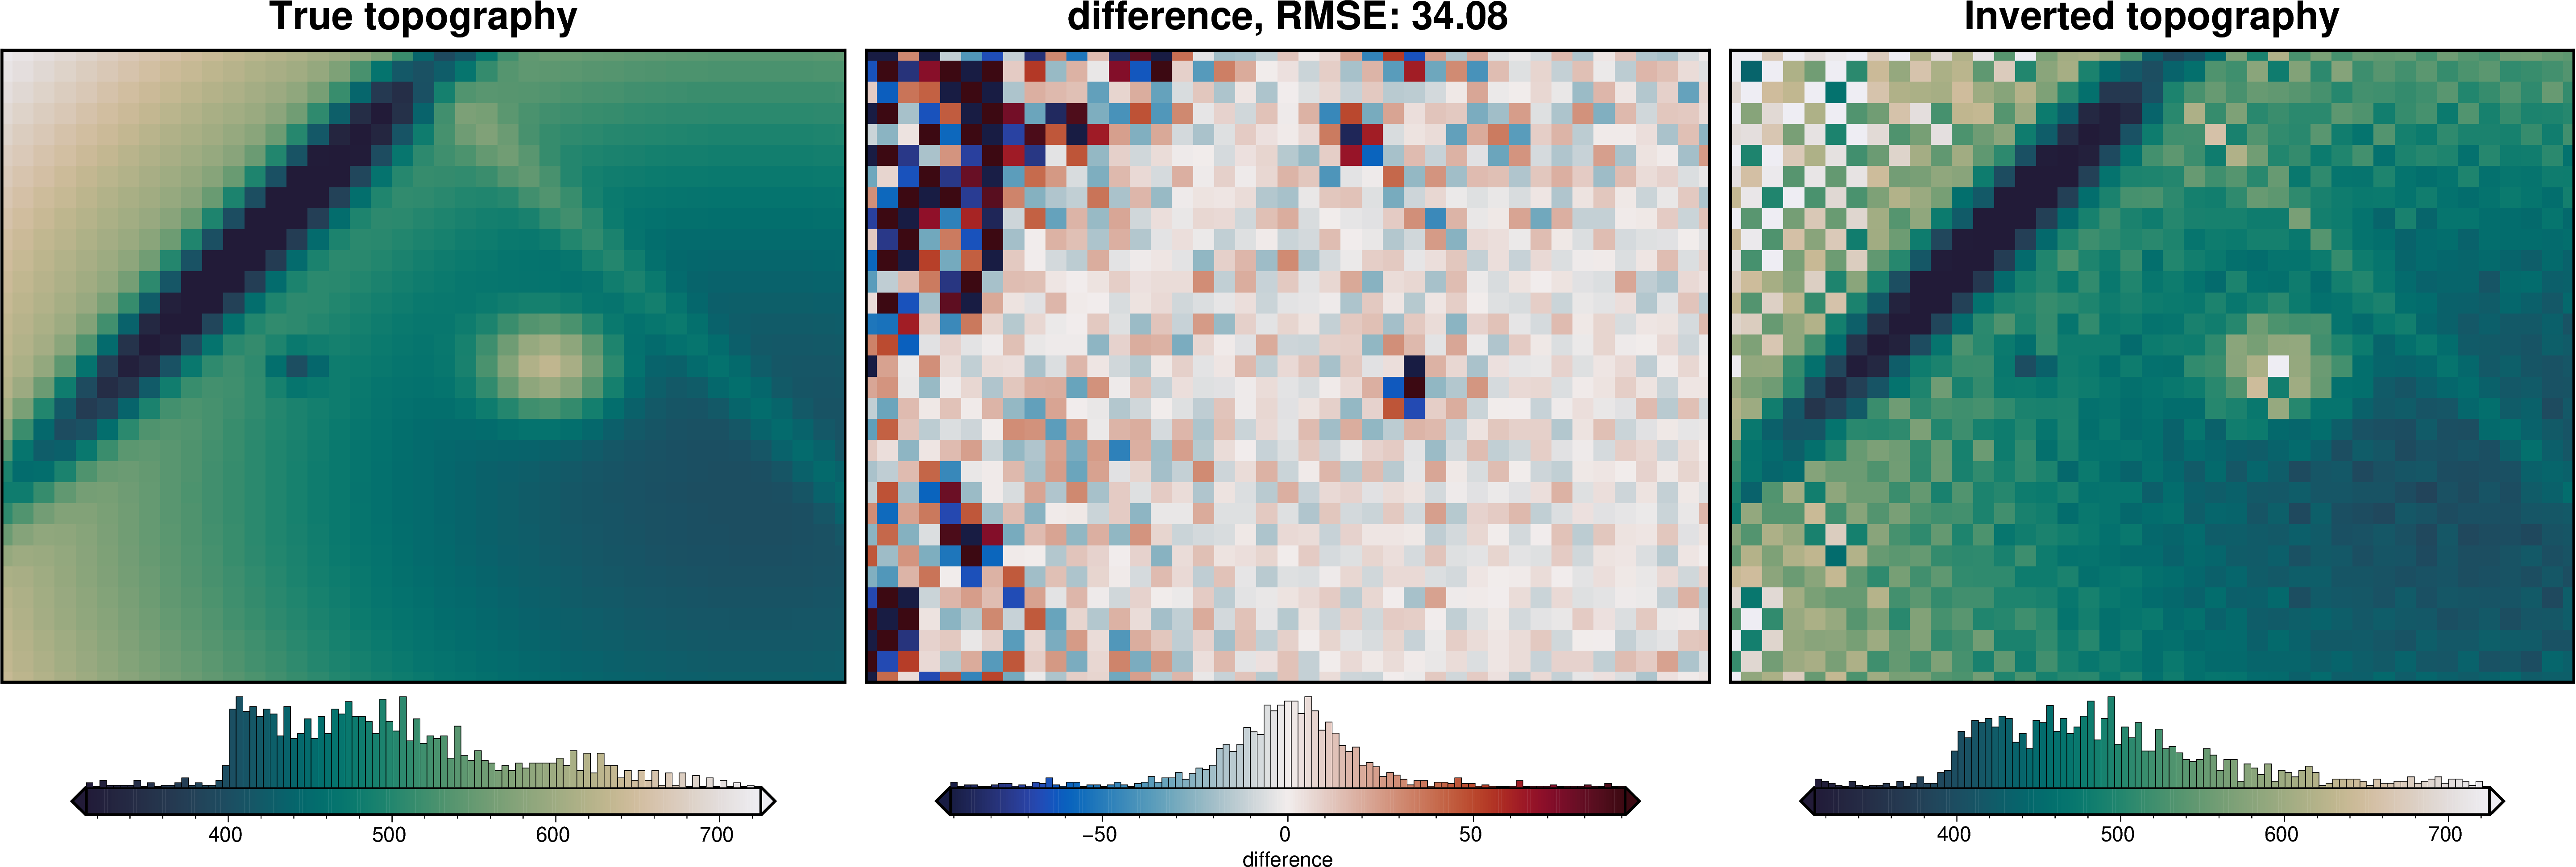

In [10]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)

Comparing this inversion with a damping value of 0.005 to the inversion with the optimal damping value of ~0.05 shows that a low damping value allows too much noise through to the final inverted topography. 

In the past example ([simple inversion](simple_inversion.ipynb)), we arbitrarily chose a damping value. Here, we show how by finding the optimal damping value using a cross-validation, we have improved the inversion's performance.

The next notebook, [density cross validation](density_cross_validation.ipynb), will show how to perform a similar cross validation for choosing a density contrast value.

#